# **Packages**

In [3]:
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import itertools

from my_module import *

from scipy.stats import mannwhitneyu

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [1]:
#!pip install missingno

# **Dataset description**

The Dataset was dowloaded from kaggle.  It contains 16 features. The output variable is weight classes (or obesity classes).  

The output variable "NObeyesdad":  
Composed of 7 classes.  
- "Insufficient_Weight";  
- "Normal_Weight";  
- "Overweight_Level_I";  
- "Overweight_Level_II";  
- "Obesity_Type_I";  
- "Obesity_Type_II";  
- "Obesity_Type_III"  

What defines these classes is the BMI (Body Mass Index).  
BMI = Weight/Height² (kg/m²)  
BMI is not part of the features but we have "Height" and "Weight", so we can easily calculate the BMI.

Features:  
The features can be divided into 3 groups.  

- **Demographic**: Gender, Age, Height, Weight, family_history_with_overweight;  

- **Dietary**: FAVC (Frequent High Calorie Food), FCVC (Vegetable Consumption Frequency), NCP (Number of Daily Meals), CAEC (Consumption of Food Between Meals);  
    
- **Lifestyle**: SMOKE (Smoking Habit), CH2O (Daily Water Intake), SCC (Calorie Monitoring), FAF (Physical Activity Frequency), TUE (Technological Device Usage Time), CALC (Alcohol Consumption Frequency), MTRANS (Main Mode of Transportation).  

The idea is to see whether features (other than weight and BMI) can be helpful to discriminate the classes.  
However, the challenge of this dataset is the presence of missing values.  
Hence, first, I will use ML to impute these missing values.  


To find features potentially helpful for class discrimination, I will use again ML.
This revealed that only "Age" was powerful enough to help discriminate *Insufficient_Weight* from the other classes.  

Next, I focused my research on gender. Are the factors that influence overweight and obesity different between males and females? This allowed me to find, using ML, that actually the young *Insufficient_Weight* people are more likely to be male, as "Age" in the female cohort is no longer a strong factor for distinguishing this class from the others. Furthermore, trying to understand what influenced my imputer to decide on gender, I found that "Height" is avery important factor (which is logical. We know that females are on average shorter than males).  

Finally, I decided to focus on the feature "CAEC" (=snacking). I found that I could identify, still using my ML outputs, a small group of short males of average age (Age = average age of the Dataset) belonging to the *Overweight_Level_I* who do not snack at all.  

# **Obesity dataset exploration**

In [4]:
train_set_df = pd.read_csv("train.csv")
train_set_df.head()

,ID,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,1,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,2,21.0,NaN,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,NaN,Sometimes,Public_Transportation,Normal_Weight
2,3,NaN,Male,NaN,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,NaN,Sometimes,Public_Transportation,Normal_Weight
3,4,27.0,NaN,NaN,87.0,Frequently,no,3.0,3.0,no,NaN,2.0,NaN,2.0,0.0,NaN,Walking,Overweight_Level_I
4,5,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
train_set_df["NObeyesdad"].value_counts()

NObeyesdad
Overweight_Level_I     290
Normal_Weight          287
Insufficient_Weight    272
Overweight_Level_II    191
Obesity_Type_I          47
Obesity_Type_III        12
Obesity_Type_II         11
Name: count, dtype: int64

In [6]:
train_set_df = train_set_df[["ID","Gender","Age","Height","Weight","family_history_with_overweight","FAVC","FCVC","NCP","CAEC","SMOKE","CH2O","SCC","FAF","TUE","CALC","MTRANS","NObeyesdad"]]

In [7]:
train_set_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              1110 non-null   int64  
 1   Gender                          760 non-null    object 
 2   Age                             801 non-null    float64
 3   Height                          873 non-null    float64
 4   Weight                          753 non-null    float64
 5   family_history_with_overweight  990 non-null    object 
 6   FAVC                            609 non-null    object 
 7   FCVC                            1110 non-null   float64
 8   NCP                             1108 non-null   float64
 9   CAEC                            790 non-null    object 
 10  SMOKE                           777 non-null    object 
 11  CH2O                            1110 non-null   float64
 12  SCC                             11

Only 3 features are complete (outside the ID). All the others have missing values. 

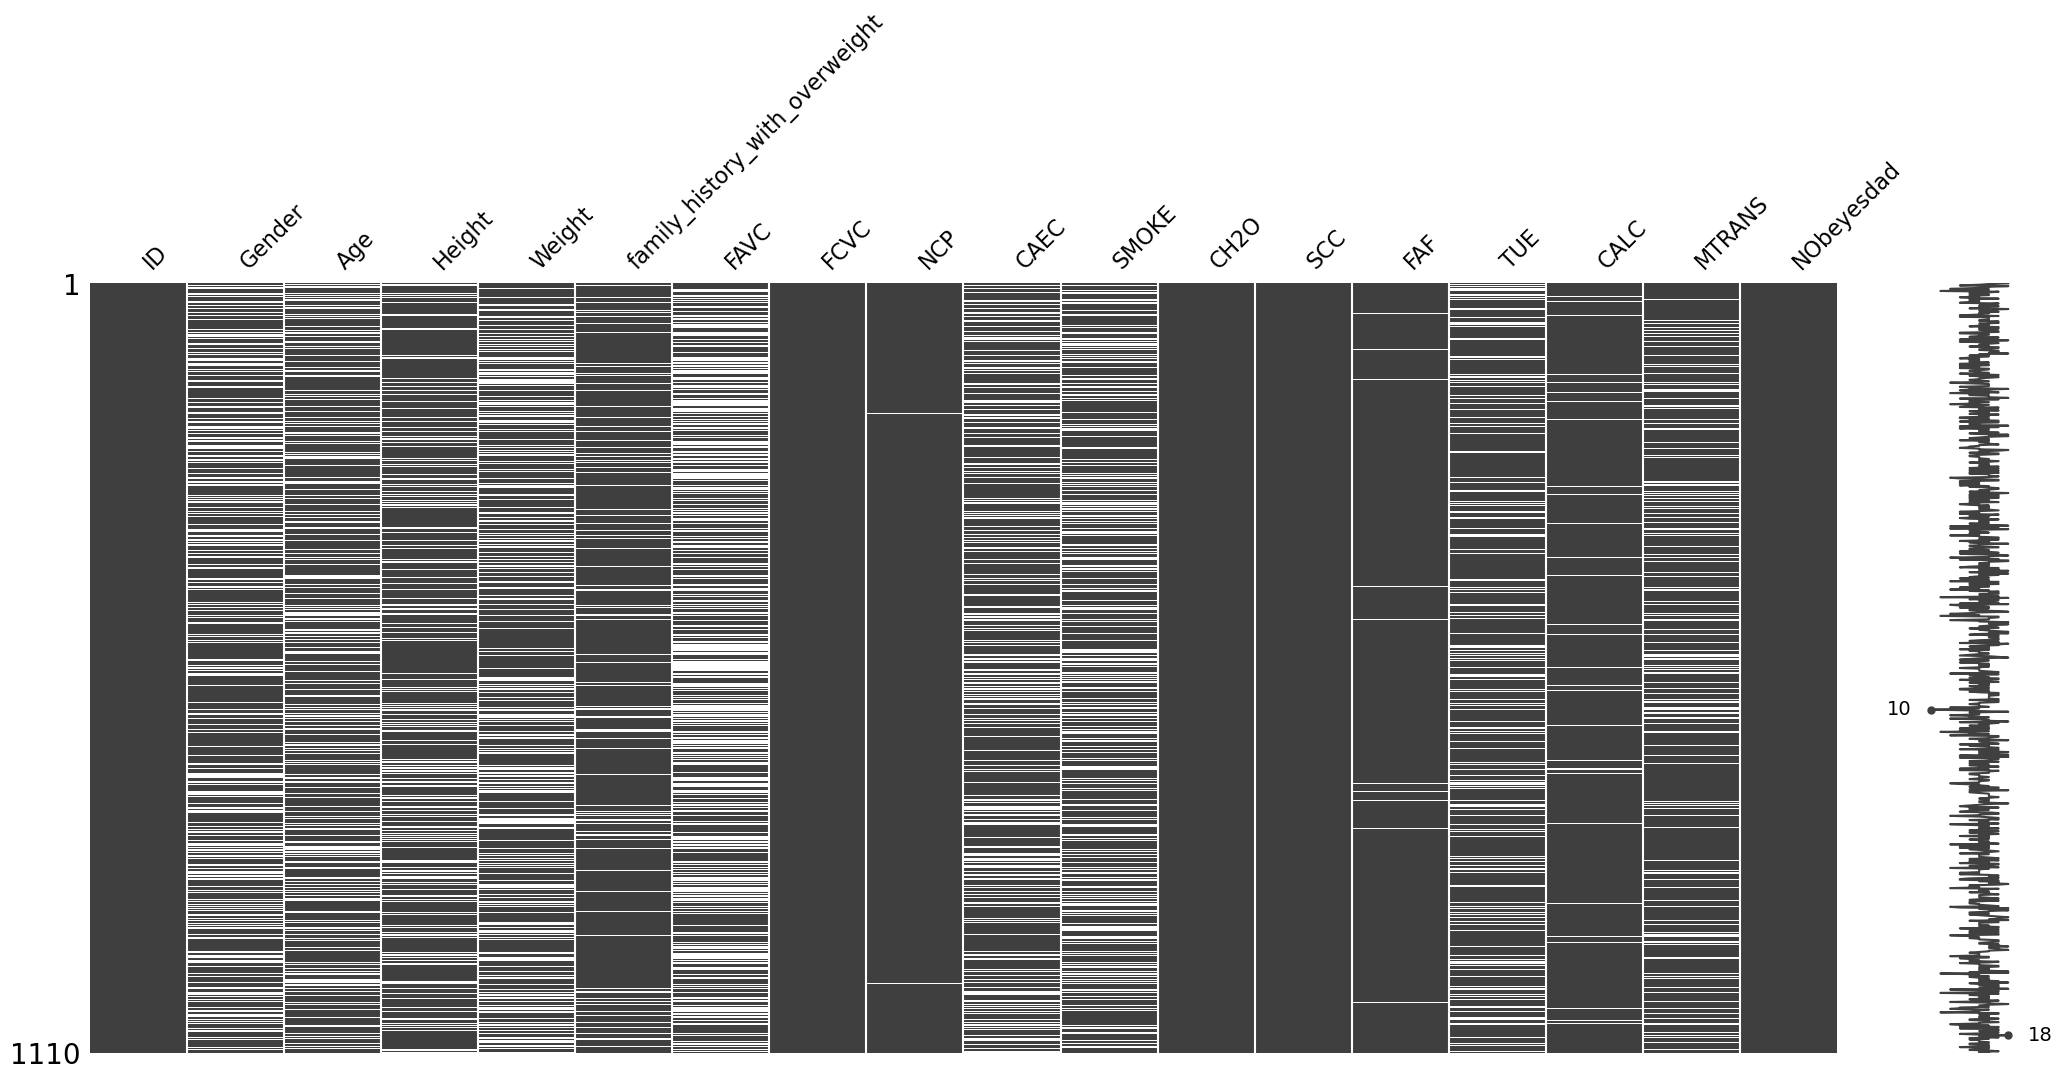

In [8]:
msno.matrix(train_set_df)
plt.show()

The category that has the most of missing values is Demographic. Those features won't be helpful to implement the missing values of the other features. 

In [9]:
@widgets.interact
def missing_vals(attribute = list(train_set_df.columns)):
    prop = train_set_df[attribute].isna().sum()/len(train_set_df)
    print(f"Proportion of missing values for the column {attribute}: {prop}")

interactive(children=(Dropdown(description='attribute', options=('ID', 'Gender', 'Age', 'Height', 'Weight', 'f…

In [10]:
miss_NCP = train_set_df[train_set_df["NCP"].isna()]
miss_NCP

,ID,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
188,189,NaN,35.0,1.78,NaN,yes,NaN,3.000000,NaN,no,no,3.000000,no,3.0,1.000000,Frequently,Automobile,Obesity_Type_I
1009,1010,Male,23.0,NaN,90.0,yes,yes,2.067817,NaN,Sometimes,NaN,1.082084,no,0.0,1.922364,Sometimes,Public_Transportation,Overweight_Level_II


In [11]:
train_set_df = train_set_df.dropna(subset=["NCP"])

In [12]:
train_set_df["Gender"].dtype

dtype('O')

In [13]:
len(train_set_df)

1108

## **Duplicates**

In [14]:
len(train_set_df["ID"].unique())

1108

In [15]:
columns_list = train_set_df.columns
duplicates = train_set_df[train_set_df.duplicated(subset=columns_list[1:], keep=False)]
duplicates

,ID,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
179,180,NaN,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Overweight_Level_I
763,764,NaN,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Overweight_Level_I


Apart from the ID number, the 2 rows are exactly the same.  
I am removing one of them.

In [16]:
train_set_df.drop(duplicates.index[0], inplace=True)

In [17]:
train_set_df.reset_index(drop=True, inplace=True)

In [18]:
train_set_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              1107 non-null   int64  
 1   Gender                          759 non-null    object 
 2   Age                             798 non-null    float64
 3   Height                          871 non-null    float64
 4   Weight                          751 non-null    float64
 5   family_history_with_overweight  987 non-null    object 
 6   FAVC                            607 non-null    object 
 7   FCVC                            1107 non-null   float64
 8   NCP                             1107 non-null   float64
 9   CAEC                            787 non-null    object 
 10  SMOKE                           775 non-null    object 
 11  CH2O                            1107 non-null   float64
 12  SCC                             11

In [19]:
missing_values = pd.DataFrame(train_set_df.isna().sum(), columns=["missing values"])
missing_values["cummulative nan"] = missing_values["missing values"].cumsum()
total_missing_vals = missing_values.loc["NObeyesdad", "cummulative nan"]
prop_missing_vals = total_missing_vals/(18*1107)
print(f"Proportion of missing values: {prop_missing_vals}")

Proportion of missing values: 0.1500050185687042


# **Imputing height and weight with BMI and output variable**

In [20]:
train_set_df["NObeyesdad"] = train_set_df["NObeyesdad"].astype("category")
weight_cats = train_set_df["NObeyesdad"].cat.categories
order_classes = ["Insufficient_Weight","Normal_Weight","Overweight_Level_I","Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II","Obesity_Type_III"]
train_set_df["NObeyesdad"] = train_set_df["NObeyesdad"].cat.reorder_categories(order_classes,ordered=True)

In [21]:
train_set_df["BMI"] = train_set_df["Weight"] / (train_set_df["Height"]**2)

-           |   Underweight   |   Normal Weight   | Overweight  |  Obese type I   |  Obese type II  |  Obese Type III
-----------   |   ------------- |  --------------   | ----------  |  ------------   |  -------------  |  --------------  
BMI (kg/m²)   |     < 18.5     |     18.5 - 24.9    | 25 - 29.9   |   30 - 34.9       |   35 - 39.9     |   > 40  

Chart found on wikipedia [BMI chart](https://en.wikipedia.org/wiki/Body_mass_index#Categories) 

In [22]:
train_set_df.groupby("NObeyesdad")["BMI"].describe()

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\1074112169.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_set_df.groupby("NObeyesdad")["BMI"].describe()


,count,mean,std,min,25%,50%,75%,max
NObeyesdad,,,,,,,,
Insufficient_Weight,145.0,17.436453,0.855126,12.998685,17.108967,17.578125,17.913122,19.082206
Normal_Weight,153.0,22.032574,1.837668,18.496499,20.545694,22.313278,23.661439,24.840980
Overweight_Level_I,151.0,26.051255,0.635887,24.171508,25.657388,26.104525,26.446729,28.769607
Overweight_Level_II,109.0,28.231017,0.866691,25.713513,27.673938,28.184761,28.896224,30.015298
Obesity_Type_I,22.0,31.708290,1.154459,30.119376,30.662768,31.561958,32.647134,33.742423
Obesity_Type_II,6.0,36.009858,1.313990,35.003199,35.205078,35.591562,36.097360,38.530612
Obesity_Type_III,8.0,43.266957,2.722505,39.493737,41.913177,42.411166,44.708373,48.572062


In [23]:
old_InsufWeight = train_set_df[(train_set_df["NObeyesdad"] == "Insufficient_Weight")\
                               &(train_set_df["BMI"] > 18.5)].copy()
old_InsufWeight

,ID,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
522,525,Female,20.225396,1.550648,44.641796,no,NaN,3.000000,2.857787,Frequently,no,1.0,no,0.754646,NaN,Sometimes,Public_Transportation,Insufficient_Weight,18.565866
547,550,Female,NaN,1.610863,49.516027,yes,NaN,2.059138,3.904858,Frequently,NaN,2.0,no,0.821977,0.0,no,Public_Transportation,Insufficient_Weight,19.082206
562,565,NaN,17.908114,1.793926,59.682591,yes,NaN,2.568063,4.000000,NaN,no,2.0,no,2.000000,NaN,no,Automobile,Insufficient_Weight,18.545503
565,568,Female,22.377998,1.699568,54.987740,yes,NaN,3.000000,3.000000,Frequently,no,2.0,no,0.139808,NaN,no,Public_Transportation,Insufficient_Weight,19.036573


In [24]:
train_set_df.loc[(train_set_df["BMI"] >= 18.5) & (train_set_df["NObeyesdad"] == "Insufficient_Weight"), "NObeyesdad"] = "Normal_Weight"
train_set_df.loc[(train_set_df["BMI"] < 25) & (train_set_df["NObeyesdad"] == "Overweight_Level_I"), "NObeyesdad"] = "Normal_Weight"
train_set_df.loc[(train_set_df["BMI"] > 29.95) & (train_set_df["NObeyesdad"] == "Overweight_Level_II"),"NObeyesdad"] = "Obesity_Type_I"
train_set_df.loc[(train_set_df["BMI"] <= 29.95)&(train_set_df["NObeyesdad"] == "Obesity_Type_I"),"NObeyesdad"] = "Overweight_Level_II"
train_set_df.loc[(train_set_df["BMI"] <= 39.9) & (train_set_df["NObeyesdad"] == "Obesity_Type_III"),"NObeyesdad"] = "Obesity_Type_II"

In [25]:
sumStat_BMI = train_set_df.groupby("NObeyesdad")["BMI"].describe()
sumStat_BMI

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\2387443699.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sumStat_BMI = train_set_df.groupby("NObeyesdad")["BMI"].describe()


,count,mean,std,min,25%,50%,75%,max
NObeyesdad,,,,,,,,
Insufficient_Weight,141.0,17.397557,0.833713,12.998685,17.099278,17.572326,17.904117,18.494228
Normal_Weight,163.0,22.046947,1.915496,18.496499,20.264848,22.313278,23.773811,24.950732
Overweight_Level_I,145.0,26.112421,0.568008,25.064403,25.711662,26.122490,26.461132,28.769607
Overweight_Level_II,108.0,28.214496,0.853313,25.713513,27.659601,28.182179,28.890723,29.937595
Obesity_Type_I,23.0,31.634682,1.181869,30.015298,30.606402,31.239414,32.641207,33.742423
Obesity_Type_II,7.0,36.507555,1.781214,35.003199,35.224971,35.918367,37.343819,39.493737
Obesity_Type_III,7.0,43.805989,2.436293,41.913063,42.002464,42.730620,44.710625,48.572062


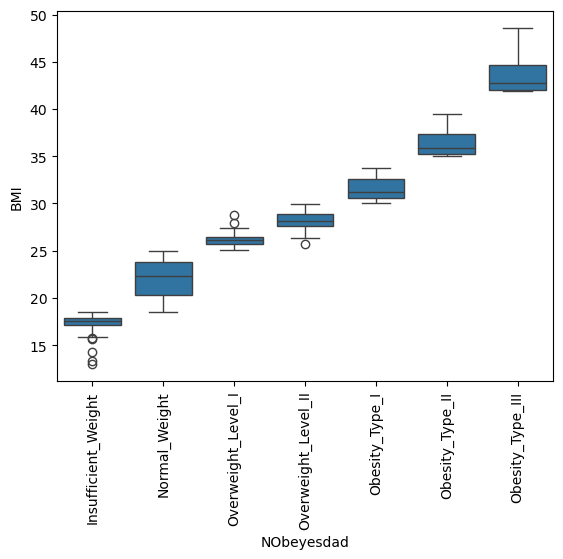

In [26]:
sns.boxplot(x="NObeyesdad",y="BMI",data=train_set_df)
plt.xticks(rotation=90)
plt.show()

In [27]:
#Height
miss_Height = train_set_df[train_set_df["Height"].isna()].copy(deep=False)
miss_Height.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236 entries, 2 to 1106
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              236 non-null    int64   
 1   Gender                          162 non-null    object  
 2   Age                             167 non-null    float64 
 3   Height                          0 non-null      float64 
 4   Weight                          157 non-null    float64 
 5   family_history_with_overweight  205 non-null    object  
 6   FAVC                            130 non-null    object  
 7   FCVC                            236 non-null    float64 
 8   NCP                             236 non-null    float64 
 9   CAEC                            180 non-null    object  
 10  SMOKE                           161 non-null    object  
 11  CH2O                            236 non-null    float64 
 12  SCC                       

In [28]:
Weight_miss_Height = miss_Height[~(miss_Height["Weight"].isna())].copy(deep=False)
Weight_miss_Height.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 2 to 1103
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              157 non-null    int64   
 1   Gender                          107 non-null    object  
 2   Age                             111 non-null    float64 
 3   Height                          0 non-null      float64 
 4   Weight                          157 non-null    float64 
 5   family_history_with_overweight  137 non-null    object  
 6   FAVC                            84 non-null     object  
 7   FCVC                            157 non-null    float64 
 8   NCP                             157 non-null    float64 
 9   CAEC                            119 non-null    object  
 10  SMOKE                           105 non-null    object  
 11  CH2O                            157 non-null    float64 
 12  SCC                       

In [29]:
def replace_in_df(df,clasW):
    df.loc[df["NObeyesdad"] == clasW,"BMI"] = sumStat_BMI.loc[clasW,"50%"]

replace_in_df(Weight_miss_Height,"Insufficient_Weight")
replace_in_df(Weight_miss_Height,"Normal_Weight")
replace_in_df(Weight_miss_Height,"Overweight_Level_I")
replace_in_df(Weight_miss_Height,"Overweight_Level_II")
replace_in_df(Weight_miss_Height,"Obesity_Type_I")
replace_in_df(Weight_miss_Height,"Obesity_Type_II")
replace_in_df(Weight_miss_Height,"Obesity_Type_III")

In [30]:
Weight_miss_Height.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 2 to 1103
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              157 non-null    int64   
 1   Gender                          107 non-null    object  
 2   Age                             111 non-null    float64 
 3   Height                          0 non-null      float64 
 4   Weight                          157 non-null    float64 
 5   family_history_with_overweight  137 non-null    object  
 6   FAVC                            84 non-null     object  
 7   FCVC                            157 non-null    float64 
 8   NCP                             157 non-null    float64 
 9   CAEC                            119 non-null    object  
 10  SMOKE                           105 non-null    object  
 11  CH2O                            157 non-null    float64 
 12  SCC                       

In [31]:
for cat in weight_cats:
    Weight_miss_Height.loc[Weight_miss_Height["NObeyesdad"] == cat,"Height"] = np.sqrt(\
        Weight_miss_Height.loc[Weight_miss_Height["NObeyesdad"] == cat,"Weight"]\
            /Weight_miss_Height.loc[Weight_miss_Height["NObeyesdad"] == cat, "BMI"])

Weight_miss_Height.head()

,ID,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
2,3,Male,NaN,1.857649,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,NaN,Frequently,Public_Transportation,Normal_Weight,22.313278
3,4,NaN,27.0,1.824956,87.0,NaN,no,3.0,3.0,NaN,NaN,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.122490
14,15,Male,NaN,1.639812,60.0,yes,NaN,3.0,1.0,Sometimes,NaN,1.0,no,1.0,1.0,Sometimes,Public_Transportation,Normal_Weight,22.313278
15,16,NaN,NaN,1.719849,66.0,yes,no,3.0,3.0,Always,NaN,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight,22.313278
18,19,Female,NaN,1.705767,82.0,yes,NaN,3.0,4.0,Frequently,yes,1.0,no,0.0,NaN,no,Automobile,Overweight_Level_II,28.182179


In [32]:
for id in Weight_miss_Height["ID"]:
    train_set_df.loc[train_set_df["ID"] == id,:] = Weight_miss_Height.loc[Weight_miss_Height["ID"] == id,:]

In [33]:
train_set_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              1107 non-null   int64   
 1   Gender                          759 non-null    object  
 2   Age                             798 non-null    float64 
 3   Height                          1028 non-null   float64 
 4   Weight                          751 non-null    float64 
 5   family_history_with_overweight  987 non-null    object  
 6   FAVC                            607 non-null    object  
 7   FCVC                            1107 non-null   float64 
 8   NCP                             1107 non-null   float64 
 9   CAEC                            787 non-null    object  
 10  SMOKE                           775 non-null    object  
 11  CH2O                            1107 non-null   float64 
 12  SCC                 

In [34]:
#Weight
missing_weight = train_set_df[train_set_df["Weight"].isna()].copy()


In [35]:
missing_weight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 7 to 1106
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              356 non-null    int64   
 1   Gender                          253 non-null    object  
 2   Age                             260 non-null    float64 
 3   Height                          277 non-null    float64 
 4   Weight                          0 non-null      float64 
 5   family_history_with_overweight  311 non-null    object  
 6   FAVC                            198 non-null    object  
 7   FCVC                            356 non-null    float64 
 8   NCP                             356 non-null    float64 
 9   CAEC                            245 non-null    object  
 10  SMOKE                           257 non-null    object  
 11  CH2O                            356 non-null    float64 
 12  SCC                       

In [36]:
height_miss_weight = missing_weight[~(missing_weight["Height"].isna())].copy()

replace_in_df(height_miss_weight,"Insufficient_Weight")
replace_in_df(height_miss_weight,"Normal_Weight")
replace_in_df(height_miss_weight,"Overweight_Level_I")
replace_in_df(height_miss_weight,"Overweight_Level_II")
replace_in_df(height_miss_weight,"Obesity_Type_I")
replace_in_df(height_miss_weight,"Obesity_Type_II")
replace_in_df(height_miss_weight,"Obesity_Type_III")

In [37]:
for cat in weight_cats:
    height_miss_weight.loc[height_miss_weight["NObeyesdad"] == cat,"Weight"] = \
    height_miss_weight.loc[height_miss_weight["NObeyesdad"] == cat,"Height"]**2 *\
    height_miss_weight.loc[height_miss_weight["NObeyesdad"] == cat, "BMI"]

height_miss_weight.head()

,ID,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
7,8,NaN,22.0,1.64,60.013794,no,no,2.0,3.0,NaN,no,2.0,no,3.0,NaN,Sometimes,Public_Transportation,Normal_Weight,22.313278
30,31,Male,29.0,1.77,81.839148,no,yes,1.0,4.0,NaN,no,3.0,no,0.0,1.0,no,Motorbike,Overweight_Level_I,26.122490
32,33,NaN,NaN,1.77,69.905270,no,no,2.0,3.0,Sometimes,no,3.0,no,1.0,1.0,Sometimes,Walking,Normal_Weight,22.313278
38,39,Male,23.0,1.65,60.747901,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,NaN,Sometimes,Public_Transportation,Normal_Weight,22.313278
39,40,Female,21.0,1.75,86.307923,NaN,yes,2.0,3.0,Sometimes,NaN,3.0,no,3.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.182179


In [38]:
for id in height_miss_weight["ID"]:
    train_set_df.loc[train_set_df["ID"] == id,:] = \
        height_miss_weight.loc[height_miss_weight["ID"] == id,:]


In [39]:
train_set_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              1107 non-null   int64   
 1   Gender                          759 non-null    object  
 2   Age                             798 non-null    float64 
 3   Height                          1028 non-null   float64 
 4   Weight                          1028 non-null   float64 
 5   family_history_with_overweight  987 non-null    object  
 6   FAVC                            607 non-null    object  
 7   FCVC                            1107 non-null   float64 
 8   NCP                             1107 non-null   float64 
 9   CAEC                            787 non-null    object  
 10  SMOKE                           775 non-null    object  
 11  CH2O                            1107 non-null   float64 
 12  SCC                 

<Axes: >

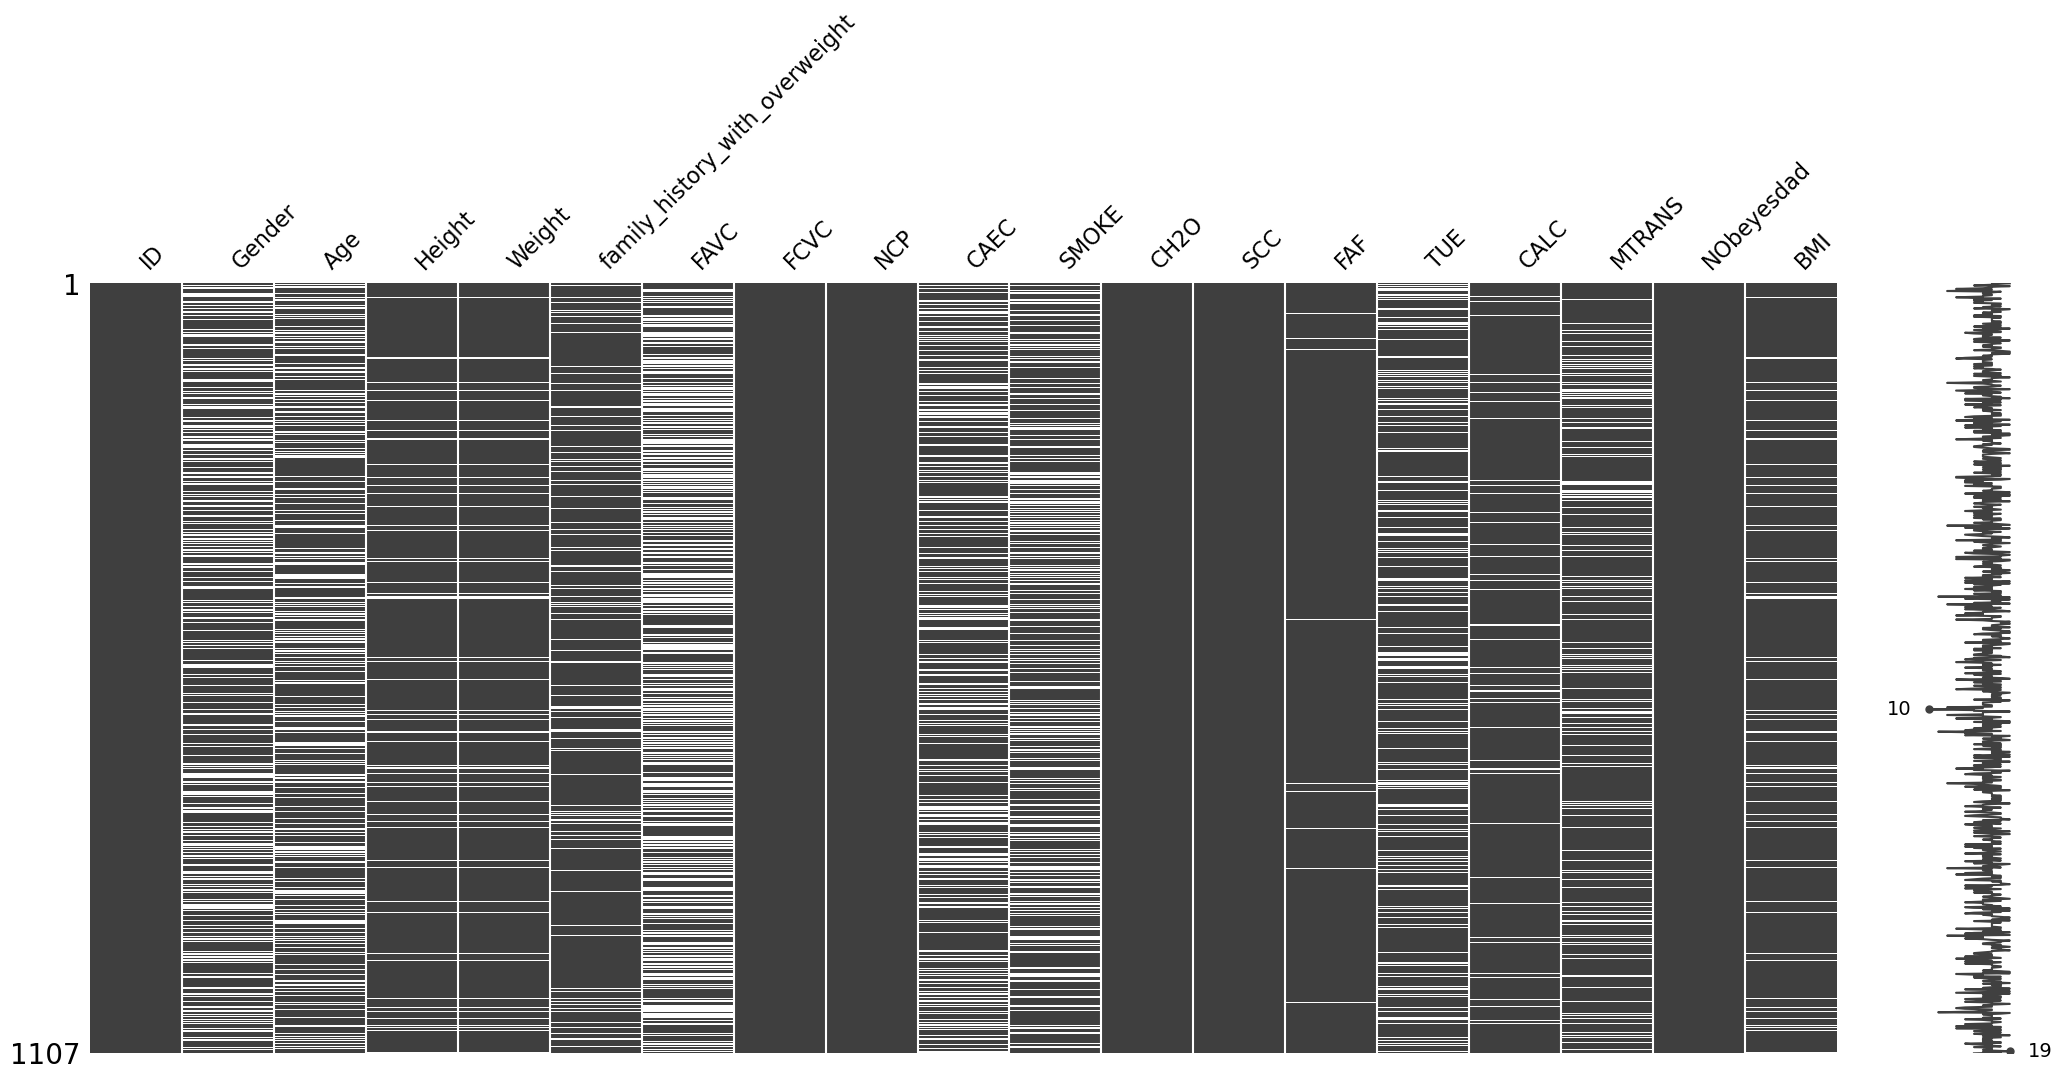

In [40]:
msno.matrix(train_set_df)

In [41]:
train_set_df.groupby("NObeyesdad")["BMI"].describe()

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\1074112169.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_set_df.groupby("NObeyesdad")["BMI"].describe()


,count,mean,std,min,25%,50%,75%,max
NObeyesdad,,,,,,,,
Insufficient_Weight,247.0,17.472559,0.634890,12.998685,17.508263,17.572326,17.625270,18.494228
Normal_Weight,280.0,22.158236,1.465529,18.496499,22.021760,22.313278,22.507444,24.950732
Overweight_Level_I,259.0,26.116853,0.424381,25.064403,26.066021,26.122490,26.214171,28.769607
Overweight_Level_II,178.0,28.201787,0.663647,25.713513,28.037445,28.182179,28.374090,29.937595
Obesity_Type_I,44.0,31.446032,0.868639,30.015298,31.215028,31.239414,31.400686,33.742423
Obesity_Type_II,9.0,36.376624,1.564303,35.003199,35.264757,35.918367,36.157025,39.493737
Obesity_Type_III,11.0,43.414946,1.963587,41.913063,42.411166,42.730620,43.718370,48.572062


-           |   Underweight   |   Normal Weight   | Overweight  |  Obese type I   |  Obese type II  |  Obese Type III
-----------   |   ------------- |  --------------   | ----------  |  ------------   |  -------------  |  --------------  
BMI (kg/m²)   |     < 18.5     |     18.5 - 24.9    | 25 - 29.9   |   30 - 34.9       |   35 - 39.9     |   > 40  


In [42]:
@widgets.interact
def missing_vals(attribute = list(train_set_df.columns)):
    prop = train_set_df[attribute].isna().sum()/len(train_set_df)
    print(f"Proportion of missing values for the column {attribute}: {prop}")

interactive(children=(Dropdown(description='attribute', options=('ID', 'Gender', 'Age', 'Height', 'Weight', 'f…

In [43]:
def BMI_imp(clas):
    median = sumStat_BMI.loc[clas,"50%"]
    train_set_df.loc[(train_set_df["NObeyesdad"] == clas)&\
                     (train_set_df["BMI"].isna()),"BMI"] = median

In [44]:
order_classes

['Insufficient_Weight',
 'Normal_Weight',
 'Overweight_Level_I',
 'Overweight_Level_II',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III']

In [45]:
for clas in order_classes:
    BMI_imp(clas)

<Axes: >

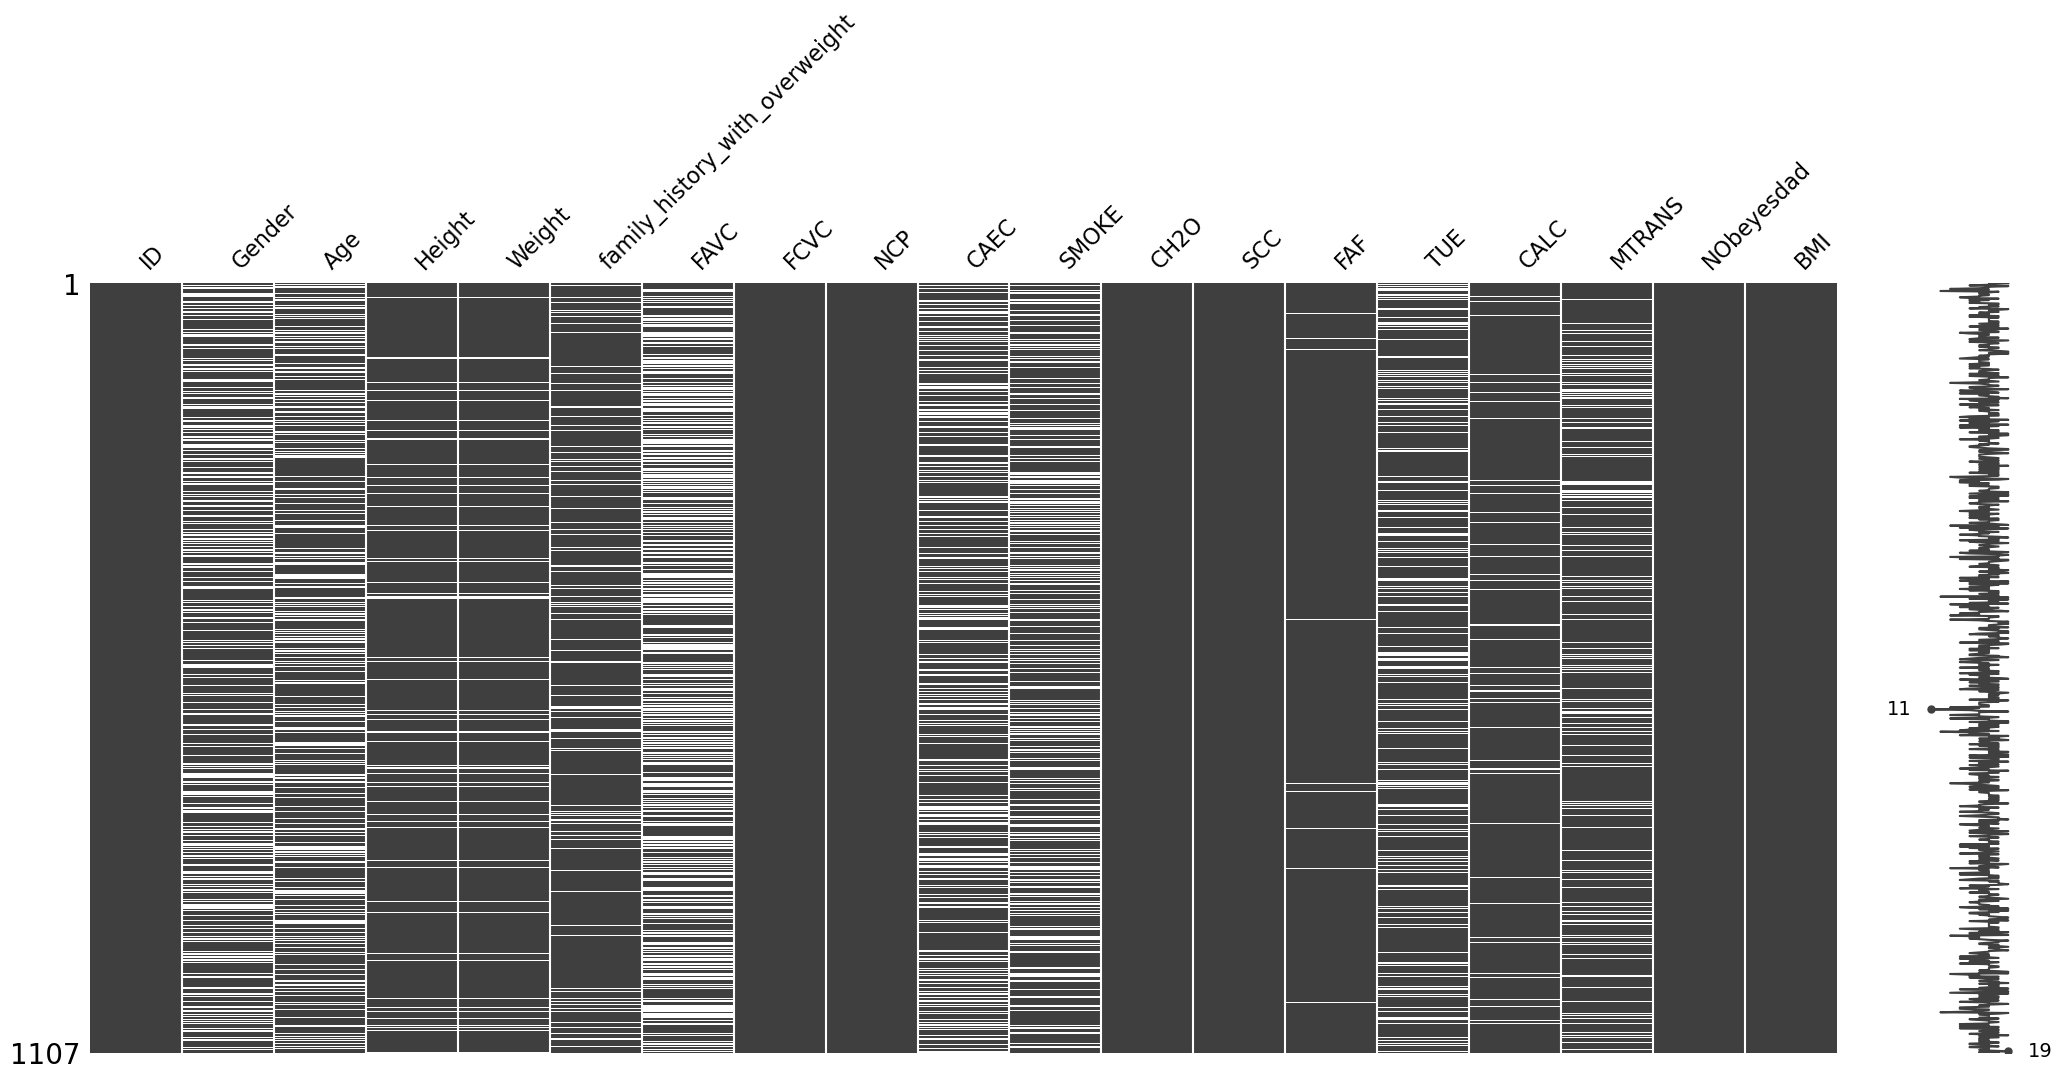

In [46]:
msno.matrix(train_set_df)

# **From object to numbers**  


## **binomial features**

In [47]:
for col in train_set_df.columns:
    if train_set_df[col].dtype == "O":
        train_set_df[col] = train_set_df[col].astype("category")

@widgets.interact
def binom_multinom(attribute=list(train_set_df.select_dtypes("category").columns)):
    n_cat = len(train_set_df[attribute].cat.categories)
    categories = train_set_df[attribute].cat.categories
    print(f"the feature {attribute} has {n_cat} categories. \nThey are: \n{categories}")

interactive(children=(Dropdown(description='attribute', options=('Gender', 'family_history_with_overweight', '…

Most of the categorical features are binomiale.

In [48]:
def binom_bool(df,col,cat_1):
    new = np.where(df[col] == cat_1,0,np.where(pd.isna(df[col]),np.nan,1))
    return new


In [49]:
train_set_df["Gender"].cat.categories[0]

'Female'

In [50]:
counts_gender = train_set_df["Gender"].value_counts(dropna=False)
counts_gender.index[2]

nan

In [51]:
data_num = train_set_df.copy()

list_binom_bool_dict = []
list_binom_cols = []
for col in data_num.select_dtypes("category").columns:
    n_cat = len(data_num[col].cat.categories)
    dict_col = {}
    if n_cat == 2:
        cats = data_num[col].cat.categories
        cat_1 = cats[0]
        data_num[col] = binom_bool(data_num,col,cat_1)
        dict_col[cat_1] = 0
        dict_col[cats[1]] = 1
        list_binom_bool_dict.append(dict_col)
        list_binom_cols.append(col)
    
print(data_num["Gender"].value_counts(dropna=False))
print(train_set_df["Gender"].value_counts(dropna=False))
print(list_binom_cols)
print(list_binom_bool_dict)



Gender
1.0    385
0.0    374
NaN    348
Name: count, dtype: int64
Gender
Male      385
Female    374
NaN       348
Name: count, dtype: int64
['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
[{'Female': 0, 'Male': 1}, {'no': 0, 'yes': 1}, {'no': 0, 'yes': 1}, {'no': 0, 'yes': 1}, {'no': 0, 'yes': 1}]


In [52]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              1107 non-null   int64   
 1   Gender                          759 non-null    float64 
 2   Age                             798 non-null    float64 
 3   Height                          1028 non-null   float64 
 4   Weight                          1028 non-null   float64 
 5   family_history_with_overweight  987 non-null    float64 
 6   FAVC                            607 non-null    float64 
 7   FCVC                            1107 non-null   float64 
 8   NCP                             1107 non-null   float64 
 9   CAEC                            787 non-null    category
 10  SMOKE                           775 non-null    float64 
 11  CH2O                            1107 non-null   float64 
 12  SCC                 

To impute the missing values, I will exclude the last columns "NObeyesdad". I should not include the dependent variable.

In [53]:
y = data_num[["NObeyesdad"]].copy()

## **Multinomial features**

In [54]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              1107 non-null   int64   
 1   Gender                          759 non-null    float64 
 2   Age                             798 non-null    float64 
 3   Height                          1028 non-null   float64 
 4   Weight                          1028 non-null   float64 
 5   family_history_with_overweight  987 non-null    float64 
 6   FAVC                            607 non-null    float64 
 7   FCVC                            1107 non-null   float64 
 8   NCP                             1107 non-null   float64 
 9   CAEC                            787 non-null    category
 10  SMOKE                           775 non-null    float64 
 11  CH2O                            1107 non-null   float64 
 12  SCC                 

In [55]:
@widgets.interact
def binom_multinom(attribute=list(data_num.select_dtypes("category").columns)):
    n_cat = len(data_num[attribute].cat.categories)
    categories = data_num[attribute].cat.categories
    print(f"the feature {attribute} has {n_cat} categories. \nThey are: \n{categories}")

interactive(children=(Dropdown(description='attribute', options=('CAEC', 'CALC', 'MTRANS', 'NObeyesdad'), valu…

In [56]:
data_num["CALC"] = data_num["CALC"].cat.reorder_categories(new_categories=["no","Sometimes","Frequently"], ordered=True)
data_num["CAEC"] = data_num["CAEC"].cat.reorder_categories(new_categories=["no","Sometimes","Frequently","Always"], ordered=True)


In [57]:
@widgets.interact
def binom_multinom(attribute=list(data_num.select_dtypes("category").columns)):
    n_cat = len(data_num[attribute].cat.categories)
    categories = data_num[attribute].cat.categories
    print(f"the feature {attribute} has {n_cat} categories. \nThey are: \n{categories}")

interactive(children=(Dropdown(description='attribute', options=('CAEC', 'CALC', 'MTRANS', 'NObeyesdad'), valu…

In [58]:
Encod_CALC = my_labelEncoder()
Encod_CALC.fit(data_num,"CALC")
dict_CALC = Encod_CALC.dict_cat
data_num["CALC_num"] = Encod_CALC.transform(data_num,"CALC")
print(data_num["CALC_num"].value_counts(dropna=False))
print(dict_CALC)

CALC_num
1       632
0       363
2        58
<NA>     54
Name: count, dtype: Int64
{'no': 0, 'Sometimes': 1, 'Frequently': 2}


In [59]:
Encod_CAEC = my_labelEncoder()
Encod_CAEC.fit(data_num,"CAEC")
dict_CAEC = Encod_CAEC.dict_cat
data_num["CAEC_num"] = Encod_CAEC.transform(data_num,"CAEC")
print(dict_CAEC)

{'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}


In [60]:
Encod_MTRANS = my_labelEncoder()
Encod_MTRANS.fit(data_num,"MTRANS")
dict_MTRANS = Encod_MTRANS.dict_cat
data_num["MTRANS_num"] = Encod_MTRANS.transform(data_num,"MTRANS")


In [61]:
Encod_y = my_labelEncoder()
Encod_y.fit(data_num,"NObeyesdad")
dict_y = Encod_y.dict_cat
data_num["NObeyesdad_num"] = Encod_y.transform(data_num,"NObeyesdad")
print(dict_y)

{'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}


In [62]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              1107 non-null   int64   
 1   Gender                          759 non-null    float64 
 2   Age                             798 non-null    float64 
 3   Height                          1028 non-null   float64 
 4   Weight                          1028 non-null   float64 
 5   family_history_with_overweight  987 non-null    float64 
 6   FAVC                            607 non-null    float64 
 7   FCVC                            1107 non-null   float64 
 8   NCP                             1107 non-null   float64 
 9   CAEC                            787 non-null    category
 10  SMOKE                           775 non-null    float64 
 11  CH2O                            1107 non-null   float64 
 12  SCC                 

In [63]:
dataNum_miss = data_num.copy()
dataNum_miss.drop(["ID","CALC","CAEC","MTRANS","NObeyesdad"], axis=1, inplace=True)

# **Imputing missing values with KNNImputer**

In [64]:
knnImput = KNNImputer(n_neighbors=5, weights="distance")
Data_num_noMiss = knnImput.fit_transform(dataNum_miss)
Data_num_noMiss = pd.DataFrame(Data_num_noMiss, columns=dataNum_miss.columns)   

In [65]:
Data_num_noMiss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1107 non-null   float64
 1   Age                             1107 non-null   float64
 2   Height                          1107 non-null   float64
 3   Weight                          1107 non-null   float64
 4   family_history_with_overweight  1107 non-null   float64
 5   FAVC                            1107 non-null   float64
 6   FCVC                            1107 non-null   float64
 7   NCP                             1107 non-null   float64
 8   SMOKE                           1107 non-null   float64
 9   CH2O                            1107 non-null   float64
 10  SCC                             1107 non-null   float64
 11  FAF                             1107 non-null   float64
 12  TUE                             11

## **Reversing from numbers to categories**

### **Multinomiales**

In [66]:
Encod_MTRANS.dict_cat

{'Automobile': 0,
 'Bike': 1,
 'Motorbike': 2,
 'Public_Transportation': 3,
 'Walking': 4}

In [67]:
X = Data_num_noMiss.copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1107 non-null   float64
 1   Age                             1107 non-null   float64
 2   Height                          1107 non-null   float64
 3   Weight                          1107 non-null   float64
 4   family_history_with_overweight  1107 non-null   float64
 5   FAVC                            1107 non-null   float64
 6   FCVC                            1107 non-null   float64
 7   NCP                             1107 non-null   float64
 8   SMOKE                           1107 non-null   float64
 9   CH2O                            1107 non-null   float64
 10  SCC                             1107 non-null   float64
 11  FAF                             1107 non-null   float64
 12  TUE                             11

In [68]:
categorical_cols = ["CALC_num","CAEC_num","MTRANS_num","Gender",\
                    "family_history_with_overweight","FAVC","SMOKE","SCC", "NObeyesdad_num"]
for col in categorical_cols:
    X[col] = X[col].astype("int32")

In [69]:
for col in categorical_cols:
    Data_num_noMiss[col] = Data_num_noMiss[col].astype("int32")

In [70]:
Data_num_noMiss["MTRANS_num"].value_counts(dropna=False)

MTRANS_num
3    732
0    220
2     79
4     47
1     29
Name: count, dtype: int64

In [71]:
Data_num_noMiss["CALC"] = Encod_CALC.reverse_transform(Data_num_noMiss,"CALC_num")
Data_num_noMiss["CAEC"] = Encod_CAEC.reverse_transform(Data_num_noMiss,"CAEC_num")
Data_num_noMiss["MTRANS"] = Encod_MTRANS.reverse_transform(Data_num_noMiss,"MTRANS_num")
Data_num_noMiss["NObeyesdad"] = Encod_y.reverse_transform(Data_num_noMiss,"NObeyesdad_num")

In [72]:
Data_num_noMiss.drop(["CALC_num","CAEC_num","MTRANS_num", "NObeyesdad_num"], axis=1, inplace=True)

In [73]:
Data_num_noMiss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1107 non-null   int32  
 1   Age                             1107 non-null   float64
 2   Height                          1107 non-null   float64
 3   Weight                          1107 non-null   float64
 4   family_history_with_overweight  1107 non-null   int32  
 5   FAVC                            1107 non-null   int32  
 6   FCVC                            1107 non-null   float64
 7   NCP                             1107 non-null   float64
 8   SMOKE                           1107 non-null   int32  
 9   CH2O                            1107 non-null   float64
 10  SCC                             1107 non-null   int32  
 11  FAF                             1107 non-null   float64
 12  TUE                             11

## **Binomiale features**

In [74]:
@widgets.interact
def binom_multinom(attribute=list(train_set_df.select_dtypes("category").columns)):
    n_cat = len(train_set_df[attribute].cat.categories)
    categories = train_set_df[attribute].cat.categories
    print(f"the feature {attribute} has {n_cat} categories. \nThey are: \n{categories}")

interactive(children=(Dropdown(description='attribute', options=('Gender', 'family_history_with_overweight', '…

In [75]:
print(list_binom_bool_dict)
print(list_binom_cols)

[{'Female': 0, 'Male': 1}, {'no': 0, 'yes': 1}, {'no': 0, 'yes': 1}, {'no': 0, 'yes': 1}, {'no': 0, 'yes': 1}]
['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']


In [76]:
list_bool_binom_dict = []
for dicti in list_binom_bool_dict:
    dicti_bool = {v:k for k,v in dicti.items()}
    list_bool_binom_dict.append(dicti_bool)


In [77]:
for col,dicti in zip(list_binom_cols,list_bool_binom_dict):
    Data_num_noMiss[col] = Data_num_noMiss[col].map(dicti)

In [78]:
print(Data_num_noMiss.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1107 non-null   object 
 1   Age                             1107 non-null   float64
 2   Height                          1107 non-null   float64
 3   Weight                          1107 non-null   float64
 4   family_history_with_overweight  1107 non-null   object 
 5   FAVC                            1107 non-null   object 
 6   FCVC                            1107 non-null   float64
 7   NCP                             1107 non-null   float64
 8   SMOKE                           1107 non-null   object 
 9   CH2O                            1107 non-null   float64
 10  SCC                             1107 non-null   object 
 11  FAF                             1107 non-null   float64
 12  TUE                             11

In [79]:
print(Data_num_noMiss.iloc[5])
print(train_set_df.iloc[5])

Gender                                     Male
Age                                    18.97192
Height                                     1.62
Weight                                     53.0
family_history_with_overweight               no
FAVC                                        yes
FCVC                                        2.0
NCP                                         3.0
SMOKE                                        no
CH2O                                        2.0
SCC                                          no
FAF                                         0.0
TUE                                    1.245442
BMI                                   20.195092
CALC                                  Sometimes
CAEC                                  Sometimes
MTRANS                               Automobile
NObeyesdad                        Normal_Weight
Name: 5, dtype: object
ID                                            6
Gender                                     Male
Age              

## **Testing the imputer on height and weight with BMI**

In [80]:
new_obesity = Data_num_noMiss.copy()

In [81]:
for col in new_obesity.columns:
    if new_obesity[col].dtype == "O":
        new_obesity[col] = new_obesity[col].astype("category")

In [82]:
print(y.value_counts())
order_classes = ["Insufficient_Weight","Normal_Weight","Overweight_Level_I","Overweight_Level_II","Obesity_Type_I","Obesity_Type_II","Obesity_Type_III"]
y["NObeyesdad"] = y["NObeyesdad"].cat.reorder_categories(new_categories=order_classes, ordered=True)
new_obesity["NObeyesdad"] = new_obesity["NObeyesdad"].cat.reorder_categories(new_categories=order_classes, ordered=True)

classes = y["NObeyesdad"].cat.categories
classes

NObeyesdad         
Normal_Weight          297
Overweight_Level_I     283
Insufficient_Weight    268
Overweight_Level_II    189
Obesity_Type_I          47
Obesity_Type_II         12
Obesity_Type_III        11
Name: count, dtype: int64


Index(['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
       'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
       'Obesity_Type_III'],
      dtype='object')

Sadly, the Obesity classes are too few to be useable (especially II and III). We will need more data for these classes if we want to draw conclusions. 

In [83]:
new_obesity.groupby("NObeyesdad")["BMI"].describe()

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\3356139958.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_obesity.groupby("NObeyesdad")["BMI"].describe()


,count,mean,std,min,25%,50%,75%,max
NObeyesdad,,,,,,,,
Insufficient_Weight,268.0,17.480377,0.610003,12.998685,17.538746,17.572326,17.583920,18.494228
Normal_Weight,297.0,22.167110,1.423280,18.496499,22.058051,22.313278,22.491349,24.950732
Overweight_Level_I,283.0,26.117331,0.405924,25.064403,26.110995,26.122490,26.141355,28.769607
Overweight_Level_II,189.0,28.200646,0.643956,25.713513,28.055706,28.182179,28.344671,29.937595
Obesity_Type_I,47.0,31.432843,0.841387,30.015298,31.239414,31.239414,31.239414,33.742423
Obesity_Type_II,12.0,36.262060,1.350045,35.003199,35.754965,35.918367,35.978032,39.493737
Obesity_Type_III,11.0,43.414946,1.963587,41.913063,42.411166,42.730620,43.718370,48.572062


-           |   Underweight   |   Normal Weight   | Overweight  |  Obese type I   |  Obese type II  |  Obese Type III
-----------   |   ------------- |  --------------   | ----------  |  ------------   |  -------------  |  --------------  
BMI (kg/m²)   |     < 18.5     |     18.5 - 24.9    | 25 - 29.9   |   30 - 34.9       |   35 - 39.9     |   > 40  


The max imputed BMI is a bit high for *Insufficient_Weight* but it's not too bad. Only for Obesity Type II the minimum value is quite low and belongs to overweight. However, the number of this class is also very low. 

In [84]:
new_obesity["ID"] = train_set_df["ID"]

In [85]:
new_obesity.loc[new_obesity["ID"] == 649]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,BMI,CALC,CAEC,MTRANS,NObeyesdad,ID
646,Female,23.056036,1.704503,51.133951,yes,yes,2.663421,3.0,no,1.04111,no,0.794402,1.391948,17.572326,no,Frequently,Public_Transportation,Insufficient_Weight,649


In [86]:
BMI_649 = new_obesity.loc[new_obesity["ID"] == 649,"Weight"] / (new_obesity.loc[new_obesity["ID"] == 649,"Height"]**2)
BMI_649

646    17.600039
dtype: float64

In [87]:
train_set_df.loc[train_set_df["ID"] == 649]

,ID,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
646,649,Female,NaN,NaN,NaN,yes,NaN,2.663421,3.0,Frequently,no,1.04111,no,0.794402,1.391948,no,Public_Transportation,Insufficient_Weight,17.572326


In [88]:
new_obesity.loc[new_obesity["ID"] == 109]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,BMI,CALC,CAEC,MTRANS,NObeyesdad,ID
108,Female,22.0,1.730253,94.637476,yes,no,2.0,3.0,no,3.0,no,3.0,2.0,31.239414,no,Sometimes,Walking,Obesity_Type_I,109


In [89]:
BMI_109 = new_obesity.loc[new_obesity["ID"] == 109,"Weight"] / (new_obesity.loc[new_obesity["ID"] == 109,"Height"]**2)
BMI_109

108    31.611406
dtype: float64

In [90]:
train_set_df.loc[train_set_df["ID"] == 109]

,ID,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
108,109,NaN,22.0,NaN,NaN,yes,NaN,2.0,3.0,Sometimes,NaN,3.0,no,3.0,2.0,no,Walking,Obesity_Type_I,31.239414


In [91]:
new_obesity.loc[(new_obesity["ID"] == 399)|(new_obesity["ID"] == 449)]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,BMI,CALC,CAEC,MTRANS,NObeyesdad,ID
396,Male,24.462787,1.802634,115.932607,yes,yes,3.0,1.0,no,1.0,no,0.0,0.0,35.918367,Sometimes,no,Public_Transportation,Obesity_Type_II,399
446,Female,24.000000,1.696324,102.270718,yes,yes,3.0,1.0,no,1.0,no,0.0,2.0,35.918367,Sometimes,Sometimes,Public_Transportation,Obesity_Type_II,449


In [92]:
BMI_399 = new_obesity.loc[new_obesity["ID"] == 399,"Weight"] / (new_obesity.loc[new_obesity["ID"] == 399,"Height"]**2)
BMI_449 = new_obesity.loc[new_obesity["ID"] == 449,"Weight"] / (new_obesity.loc[new_obesity["ID"] == 449,"Height"]**2)
print(BMI_399)
print(BMI_449)

396    35.677196
dtype: float64
446    35.541321
dtype: float64


In [93]:
train_set_df.loc[(train_set_df["ID"] == 399)|(train_set_df["ID"] == 449)]

,ID,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
396,399,Male,NaN,NaN,NaN,yes,yes,3.0,1.0,NaN,NaN,1.0,no,0.0,0.0,Sometimes,Public_Transportation,Obesity_Type_II,35.918367
446,449,Female,24.0,NaN,NaN,yes,yes,3.0,1.0,Sometimes,NaN,1.0,no,0.0,2.0,Sometimes,Public_Transportation,Obesity_Type_II,35.918367


In these few examples, we can see that the BMI (imputed median of each class) is very close to the real BMI calculated with the imputed weight and height.  
This suggests that the imputer worked quite well with these 2 features (Weight and height).

# **EDA**  
Now I have imputed the missing values, I can start exploring the dataset to look for insights.  
since there are 15 features and 7 classes, a manual exploration would be too fastidious.  
I am therefore using MLs to get a first glance of the data.  
The strategies I am using to address the 3 questions listed in the intro is as follow:  
- Use **Logistic Regression** to get the feature importance by their coeficient value for each class;  
- Having a focus at the most impactful to understand why they came out as such;  
- Compare the distributions of the features between before imputing and after to understand the "reason" of the value decision by the imputer.  

The main goal of this excersise is to test whether we can find helpful features for weight class discrimination. 

## **1) From Demographic, dietary and lifestyle, which one is more prevalent to determine the obesity?**

Features:  
The features can be divided into 3 groups.  

- **Demographic**: Gender, Age, Height, Weight, family_history_with_overweight;  

- **Dietary**: FAVC (Frequent High Calorie Food), FCVC (Vegetable Consumption Frequency), NCP (Number of Daily Meals), CAEC (Consumption of Food Between Meals);  
    
- **Lifestyle**: SMOKE (Smoking Habit), CH2O (Daily Water Intake), SCC (Calorie Monitoring), FAF (Physical Activity Frequency), TUE (Technological Device Usage Time), CALC (Alcohol Consumption Frequency), MTRANS (Main Mode of Transportation).  
 
One would think the Dietary would be more prevalent, however, not only this category has at the begining the least number of features (4), but I am removing one of them FAVC since it has too many null values (45%) to be interpretable and the imputed values trusted.  
Hence, would the 3 remaining features be the most influencial?  

Note that among the Demographic subgroup is the feature "Weight". Together with "Height", they are sufficient to determine the weight class. Hence, they are important to keep to impute the missing values.  
However, for the EDA, "Weight" has a too heavy influence (even without the "Height"). Hence, I am removing it in addition to "FAVC". 

In [94]:
new_obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          1107 non-null   category
 1   Age                             1107 non-null   float64 
 2   Height                          1107 non-null   float64 
 3   Weight                          1107 non-null   float64 
 4   family_history_with_overweight  1107 non-null   category
 5   FAVC                            1107 non-null   category
 6   FCVC                            1107 non-null   float64 
 7   NCP                             1107 non-null   float64 
 8   SMOKE                           1107 non-null   category
 9   CH2O                            1107 non-null   float64 
 10  SCC                             1107 non-null   category
 11  FAF                             1107 non-null   float64 
 12  TUE                 

### **FAVC Frequent high calory food**  
This feature had the most of missing values (45%). Should I keep it for my analysis, or should I remove it as the percentage of missing values is too high?  
If the distribution of the non missing values was completely random and the Imputer couldn't use other information than the weight class (with BMI) and the distribution of "yes" and "no" inside each class, we would expect after imputing toughly the same distribution.

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\3432755908.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(classes, rotation=90)


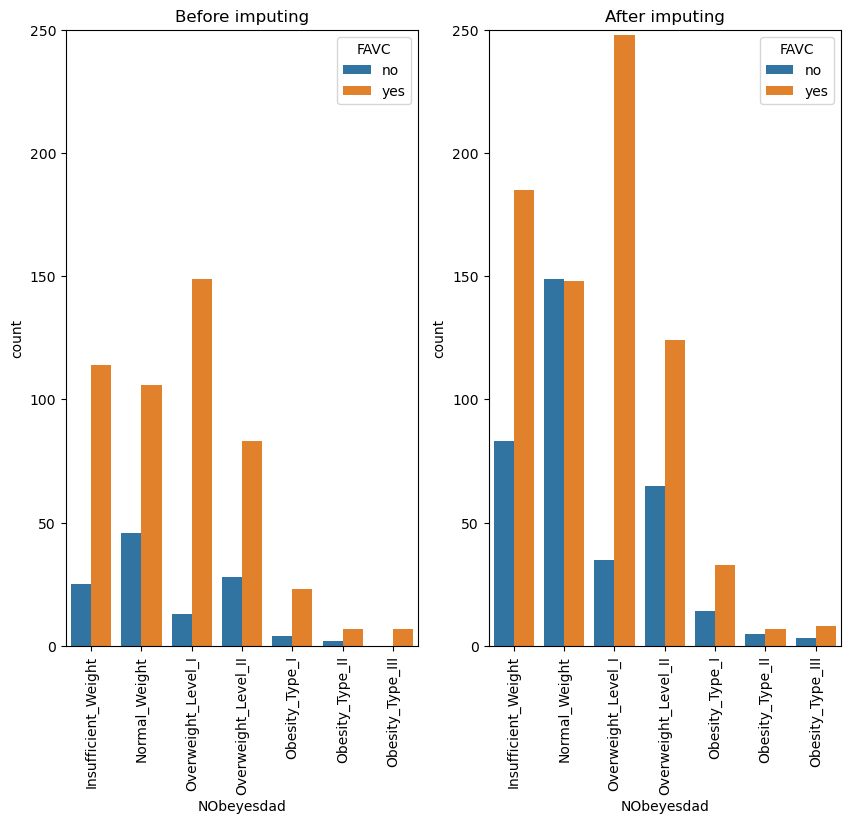

In [95]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
sns.countplot(x="NObeyesdad", data=train_set_df, hue="FAVC", ax=ax1)
ax1.set_title("Before imputing")
ax1.set_xticklabels(classes, rotation=90)
ax1.set_ylim(0,250)
sns.countplot(x="NObeyesdad", data=new_obesity, hue="FAVC",ax=ax2)
ax2.set_title("After imputing")
ax2.set_ylim(0,250)
plt.xticks(rotation=90)
plt.show()

Interestingly however, we can see a huge difference of distribution of "yes" and "no" in the *Normal_Weight* class.  
This suggests that there are other features values that are more oftenly present in the "no" category and when the class is *Normal_Weight*.  
There is clearly an informative imbalance that renders "FAVC" feature worth to keep.  
Hyp: there are common grounds among the original "no" of *Normal_Weight* (less variable than the "yes" category perhaps)

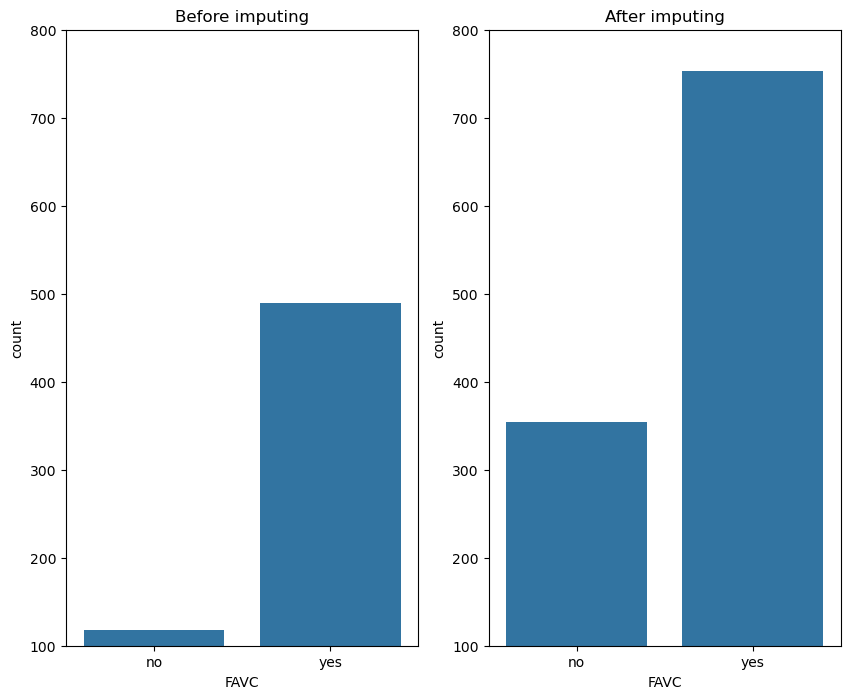

In [96]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
sns.countplot(x="FAVC", data=train_set_df,ax=ax1)
ax1.set_title("Before imputing")
ax1.set_ylim(100,800)
sns.countplot(x="FAVC", data=new_obesity, ax=ax2)
ax2.set_title("After imputing")
ax2.set_ylim(100,800)
plt.show()

This hypothesis is confirmed even when looking at the distribution of "yes" and "no" in the entire dataset.

In [97]:
print(train_set_df["FAVC"].value_counts(normalize=True, dropna=False))
print(new_obesity["FAVC"].value_counts(normalize=True))

FAVC
NaN    0.451671
yes    0.441734
no     0.106594
Name: proportion, dtype: float64
FAVC
yes    0.680217
no     0.319783
Name: proportion, dtype: float64


As mentioned before, the missing values on this feature represent 45% of the entire column.  However, proportionally, the imputer imputed more "no" than "yes".  
And it changed the distribution mainly in the *Normal_Weight* class but also to a less extent in *Insufficient_Weight*.  
This suggests that the imputer used other feature information (other than NObeyesdad and BMI) to impute more "no"s than "yes"s. 

### **Logistic regression on the dataset**

In [98]:
y.shape

(1107, 1)

In [99]:
y_resh = y.values.reshape(-1)
y_resh.shape

(1107,)

In [100]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1107 non-null   int32  
 1   Age                             1107 non-null   float64
 2   Height                          1107 non-null   float64
 3   Weight                          1107 non-null   float64
 4   family_history_with_overweight  1107 non-null   int32  
 5   FAVC                            1107 non-null   int32  
 6   FCVC                            1107 non-null   float64
 7   NCP                             1107 non-null   float64
 8   SMOKE                           1107 non-null   int32  
 9   CH2O                            1107 non-null   float64
 10  SCC                             1107 non-null   int32  
 11  FAF                             1107 non-null   float64
 12  TUE                             11

In [101]:
X_mod = X.drop(["NObeyesdad_num","Weight","BMI"], axis=1)
stScale = StandardScaler()
X_scale = stScale.fit_transform(X_mod)

In [102]:
logReg = LogisticRegression(max_iter=1000)

logReg.fit(X_scale,y_resh)

LogisticRegression(max_iter=1000)

In [103]:
feature_coefs = logReg.coef_
feature_coefs.shape

(7, 15)

In [104]:
df_coefs = pd.DataFrame(feature_coefs, columns=X_mod.columns, index=classes)


In [105]:
def most_import_negFeature(df_coefs, weight_class):
    sorted_coefs = df_coefs.loc[weight_class].sort_values()
    return sorted_coefs[:3]

def most_import_posFeature(df_coefs, weight_class):
    sorted_coefs = df_coefs.loc[weight_class].sort_values(ascending=False)
    return sorted_coefs[:3]

In [106]:
@widgets.interact
def most_important_negFeature(weight_class = classes):
    print(most_import_negFeature(df_coefs, weight_class))

interactive(children=(Dropdown(description='weight_class', options=('Insufficient_Weight', 'Normal_Weight', 'O…

In [107]:
@widgets.interact
def most_important_posFeature(weight_class = classes):
    print(most_import_posFeature(df_coefs, weight_class))

interactive(children=(Dropdown(description='weight_class', options=('Insufficient_Weight', 'Normal_Weight', 'O…

In [108]:
def highest_coef_class(coef_df, class_list):
    best_coef_class = {}
    coef_df = coef_df.abs()
    for clas in class_list:
        sorted_coef = coef_df.loc[clas].sort_values(ascending=False)
        sorted_feature = coef_df.loc[clas].sort_values(ascending=False).index
        dici = {}
        for i in range(3):
            dici[sorted_feature[i]] = sorted_coef[i]
        best_coef_class[clas] = dici
    return best_coef_class

In [109]:
highest_coef_ob = highest_coef_class(df_coefs,classes)
highest_coef_ob

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\3471518129.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dici[sorted_feature[i]] = sorted_coef[i]


{'Insufficient_Weight': {'Age': 2.030363588054507,
  'CAEC_num': 0.8933611634748767,
  'family_history_with_overweight': 0.85811953691651},
 'Normal_Weight': {'CAEC_num': 0.7973491695388826,
  'family_history_with_overweight': 0.5760328395800157,
  'Height': 0.5138747261591408},
 'Overweight_Level_I': {'FCVC': 0.6778602670642015,
  'Age': 0.5837207073349281,
  'Gender': 0.5210290143626276},
 'Overweight_Level_II': {'CAEC_num': 1.0125106604394274,
  'Age': 0.920788383278917,
  'Height': 0.6070844104184263},
 'Obesity_Type_I': {'FCVC': 1.807150561766541,
  'Gender': 1.5056164380295305,
  'CAEC_num': 1.0771579944933627},
 'Obesity_Type_II': {'FAVC': 0.5496016995027142,
  'FCVC': 0.4568331147508128,
  'SCC': 0.45606461899158296},
 'Obesity_Type_III': {'Age': 0.6512684961817918,
  'FCVC': 0.5147011793420483,
  'NCP': 0.3874344235411078}}

Overall, apart from "Age" in *Insufficient_Weight* and "FCVC" in *Obesity_Type_I*, none of the other features seem to individually be helpful to discriminate a class from the others.

### **Age**  
To understand better the feature importance for each class, I will focus now on the feature "Age" (from **Demographic**). this feature appears negatively (*Insufficient_Weight*) or positively (*Overweight_Level_II*, *Obesity_Type_III*, *Overweight_Level_I*).  
I will therefore analyse the age distribution relative to each class.

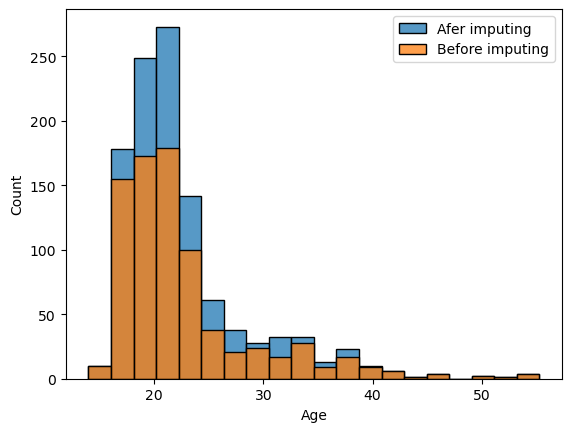

In [110]:
sns.histplot(new_obesity["Age"], bins=20)
sns.histplot(train_set_df["Age"], bins=20)
plt.legend(["Afer imputing","Before imputing"])
plt.show()

The distribution of "Age" follows its original distribution.  
Furthermore we can see that our dataset is young with an average around 20 years old with a right tail distribution. 

In [111]:
print(df_coefs["Age"].sort_values(ascending=False))

Overweight_Level_II    0.920788
Obesity_Type_III       0.651268
Overweight_Level_I     0.583721
Obesity_Type_I         0.333972
Obesity_Type_II       -0.005723
Normal_Weight         -0.453663
Insufficient_Weight   -2.030364
Name: Age, dtype: float64


If we believe the model, the oldest population should be amongst the Overweight_Level_II while the youngest population should be amongst the Insuficient_Weight.

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\2561808632.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(classes, rotation=90)


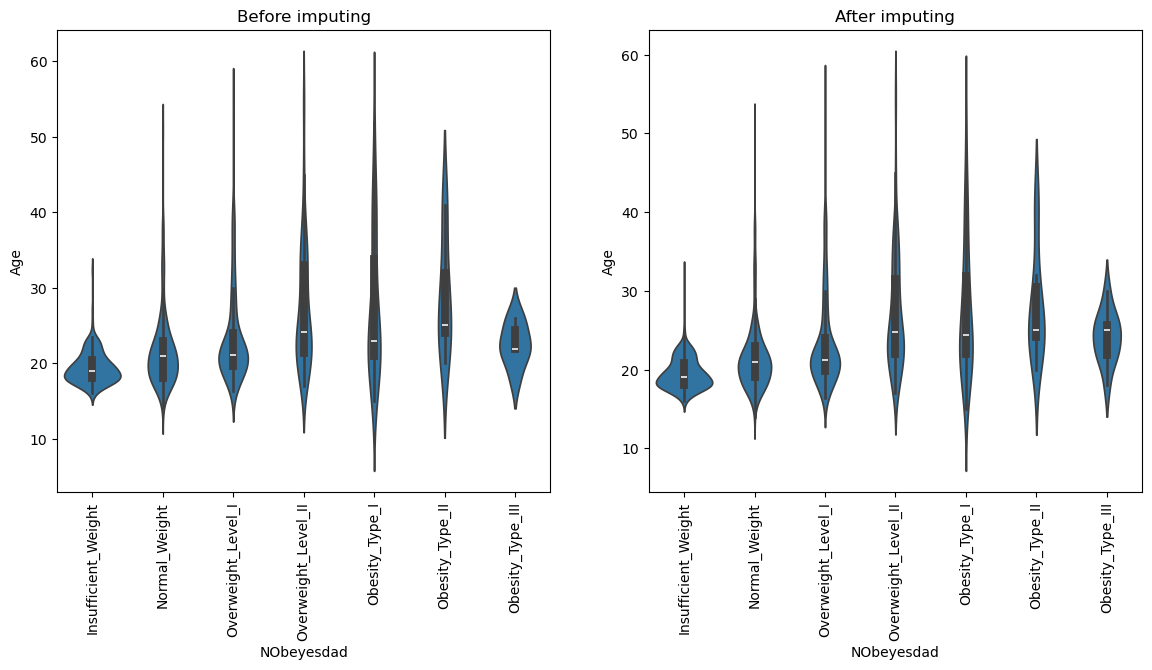

In [112]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
sns.violinplot(y="Age", x="NObeyesdad", data=train_set_df, ax=ax1)
ax1.set_xticklabels(classes, rotation=90)
ax1.set_title("Before imputing")
sns.violinplot(x="NObeyesdad", y="Age", data=new_obesity, ax=ax2)
plt.xticks(rotation=90)
ax2.set_title("After imputing")
plt.show()

When comparing the "Age" distribution among the classes before and after i mputing, we do not see stricking differences.  
This suggests homogeneity of variance within each class (?).  
Note that consistent with the logistic regression result, the median "Age" of *Insufficient_Weight* class is the youngest (highest negative coef value in the logistic regression model).

In [113]:
missing_age = {}
for clas in classes:
    missing_val = len(train_set_df.loc[(train_set_df["NObeyesdad"] == clas)&(train_set_df["Age"].isna())])
    missing_age[clas] = missing_val

missing_age

{'Insufficient_Weight': 77,
 'Normal_Weight': 80,
 'Overweight_Level_I': 79,
 'Overweight_Level_II': 54,
 'Obesity_Type_I': 11,
 'Obesity_Type_II': 3,
 'Obesity_Type_III': 5}

In [114]:
train_set_df["NObeyesdad"].value_counts()

NObeyesdad
Normal_Weight          297
Overweight_Level_I     283
Insufficient_Weight    268
Overweight_Level_II    189
Obesity_Type_I          47
Obesity_Type_II         12
Obesity_Type_III        11
Name: count, dtype: int64

However, proportionally the missing values are not that high (<30%), so I'm not sure, unless drastic differential decision, it would have been visible.

To test whether the "Age" in *Insufficient_Weight* class is significantly younger compared to the other classes, I am doing a Mann Whitney U test over all the classes with an additional Bonferroni correction (multiple comparisons). 

In [115]:
sum_stat_Age_per_class = new_obesity.groupby("NObeyesdad")["Age"].describe()
sum_stat_Age_per_class

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\3759887720.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_stat_Age_per_class = new_obesity.groupby("NObeyesdad")["Age"].describe()


,count,mean,std,min,25%,50%,75%,max
NObeyesdad,,,,,,,,
Insufficient_Weight,268.0,19.533426,2.051882,16.000000,18.000000,19.053421,20.879592,32.383858
Normal_Weight,297.0,21.503927,4.348669,14.000000,19.000000,21.000000,23.000000,51.000000
Overweight_Level_I,283.0,23.318304,5.707712,16.370009,19.771104,21.191807,24.049711,55.000000
Overweight_Level_II,189.0,27.195503,7.484966,17.000000,21.994603,24.751511,31.562299,55.246250
Obesity_Type_I,47.0,27.491544,8.503920,15.000000,22.034865,24.417476,31.825119,52.000000
Obesity_Type_II,12.0,28.016606,6.807846,20.000000,24.195485,25.000000,30.500000,41.000000
Obesity_Type_III,11.0,24.101983,3.224655,18.000000,21.876973,25.076134,25.598107,29.976322


In [116]:
classes_age_test = multiple_MannWitU(new_obesity, col_name="Age", target_col="NObeyesdad")
classes_age_test

{('Insufficient_Weight', 'Normal_Weight'): 2.4305137024272677e-09,
 ('Insufficient_Weight', 'Overweight_Level_I'): 2.5915389926819363e-23,
 ('Insufficient_Weight', 'Overweight_Level_II'): 5.020531372433349e-42,
 ('Insufficient_Weight', 'Obesity_Type_I'): 3.973228339034929e-13,
 ('Insufficient_Weight', 'Obesity_Type_II'): 1.2979604935996295e-06,
 ('Insufficient_Weight', 'Obesity_Type_III'): 0.00039946792188175694,
 ('Normal_Weight', 'Overweight_Level_I'): 0.00036734175374352623,
 ('Normal_Weight', 'Overweight_Level_II'): 7.582056767768973e-23,
 ('Normal_Weight', 'Obesity_Type_I'): 8.151687866407187e-07,
 ('Normal_Weight', 'Obesity_Type_II'): 0.0006033129269259136,
 ('Normal_Weight', 'Obesity_Type_III'): 0.08435965493843715,
 ('Overweight_Level_I', 'Overweight_Level_II'): 4.6104341844399533e-11,
 ('Overweight_Level_I', 'Obesity_Type_I'): 0.002382709479300125,
 ('Overweight_Level_I', 'Obesity_Type_II'): 0.02576719450164584,
 ('Overweight_Level_I', 'Obesity_Type_III'): 1.40012312604245,
 (

the distribution of age of the *Insuficient_Weight* class is significantly different from all the other classes. This is not the case for the other groups. This is the reason why for a large group like this one, "Age" has such a high absolute value compared to the other features.


### **FCVC**  
FCVC has the particularity to have no missing values and it has the second highest coefficient value in *Obesity_Type_I*

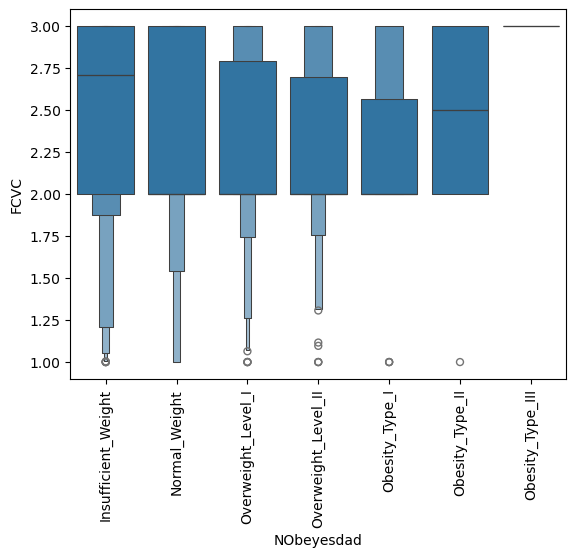

In [117]:
sns.boxenplot(x="NObeyesdad", y="FCVC", data=new_obesity)
plt.xticks(rotation=90)
plt.show()

In [118]:
highest_coef_ob

{'Insufficient_Weight': {'Age': 2.030363588054507,
  'CAEC_num': 0.8933611634748767,
  'family_history_with_overweight': 0.85811953691651},
 'Normal_Weight': {'CAEC_num': 0.7973491695388826,
  'family_history_with_overweight': 0.5760328395800157,
  'Height': 0.5138747261591408},
 'Overweight_Level_I': {'FCVC': 0.6778602670642015,
  'Age': 0.5837207073349281,
  'Gender': 0.5210290143626276},
 'Overweight_Level_II': {'CAEC_num': 1.0125106604394274,
  'Age': 0.920788383278917,
  'Height': 0.6070844104184263},
 'Obesity_Type_I': {'FCVC': 1.807150561766541,
  'Gender': 1.5056164380295305,
  'CAEC_num': 1.0771579944933627},
 'Obesity_Type_II': {'FAVC': 0.5496016995027142,
  'FCVC': 0.4568331147508128,
  'SCC': 0.45606461899158296},
 'Obesity_Type_III': {'Age': 0.6512684961817918,
  'FCVC': 0.5147011793420483,
  'NCP': 0.3874344235411078}}

In [119]:
multiple_MannWitU(new_obesity,col_name="FCVC",target_col="NObeyesdad")

{('Insufficient_Weight', 'Normal_Weight'): 0.49432530940866404,
 ('Insufficient_Weight', 'Overweight_Level_I'): 1.7206273261706063e-06,
 ('Insufficient_Weight', 'Overweight_Level_II'): 1.0822187221274036e-05,
 ('Insufficient_Weight', 'Obesity_Type_I'): 0.04319054384435454,
 ('Insufficient_Weight', 'Obesity_Type_II'): 18.61684022046392,
 ('Insufficient_Weight', 'Obesity_Type_III'): 0.0013469019537895321,
 ('Normal_Weight', 'Overweight_Level_I'): 2.8189364708782136,
 ('Normal_Weight', 'Overweight_Level_II'): 2.7512432975928447,
 ('Normal_Weight', 'Obesity_Type_I'): 3.0197004426357146,
 ('Normal_Weight', 'Obesity_Type_II'): 11.739063308331488,
 ('Normal_Weight', 'Obesity_Type_III'): 0.002562354839497196,
 ('Overweight_Level_I', 'Overweight_Level_II'): 12.78780126935239,
 ('Overweight_Level_I', 'Obesity_Type_I'): 6.011882425861006,
 ('Overweight_Level_I', 'Obesity_Type_II'): 5.375851250621944,
 ('Overweight_Level_I', 'Obesity_Type_III'): 1.4512924721425022e-05,
 ('Overweight_Level_II', 'Ob

Although "FCVC" has the second highest coeficient value (1.81) in *Obesity_Type_I*, I couldn't find a significant difference with the other classes.  
*Obesity_Type_I* has 47 individuals (17.5% the size of *Insufficient_Weight* which is not even the largest group). Perhaps if we can increase its size (as well as the other obesity classes) will we get significance for this feature. But for now we cannot conclude anything. 

### **Conclusion**  
The 3 Obesity classes cannot be use with confidence for insight as they are in extreme minority compared to the other classes.
From the logistic regression model, the only feature that clearly outstanded in class discrimination (*Insufficient_Weight*) is "Age". People from this dataset who belong to *Insufficient_Weight* class are more likely to be younger than the others.  
None of the other features strick from the others.

## **2) Difference between males and females**  
The dataset can be divided into 2 genders: males and females.  
Although in general (appart from "Age") no features show particular weight into classes discrimination, we can still ask whether if we separate the 2 genders, we will see a difference. 

In [120]:
new_obesity["Gender"].value_counts()

Gender
Female    633
Male      474
Name: count, dtype: int64

In [121]:
train_set_df["Gender"].value_counts(dropna=False, normalize=True)

Gender
Male      0.347787
Female    0.337850
NaN       0.314363
Name: proportion, dtype: float64

In [122]:
train_set_df.groupby("NObeyesdad")["Gender"].value_counts(dropna=False)

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\2983619358.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_set_df.groupby("NObeyesdad")["Gender"].value_counts(dropna=False)


NObeyesdad           Gender
Insufficient_Weight  Female    127
                     Male       72
                     nan        69
Normal_Weight        Male      106
                     nan       103
                     Female     88
Overweight_Level_I   Male       99
                     nan        93
                     Female     91
Overweight_Level_II  Male       79
                     nan        63
                     Female     47
Obesity_Type_I       Male       22
                     nan        15
                     Female     10
Obesity_Type_II      Male        7
                     Female      3
                     nan         2
Obesity_Type_III     Female      8
                     nan         3
                     Male        0
Name: count, dtype: int64

Before imputing we had basically 1/3 of each (Male, female and Nan).  
After imputing we have now more Females than Males. And this was true even after imputing without the output variable.
This would suggest that the combination of the other features helped in determinig the gender of the person.  

In [123]:
train_set_df["NObeyesdad"] = train_set_df["NObeyesdad"].cat.reorder_categories(new_categories=order_classes, ordered=True)

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\721588921.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\721588921.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


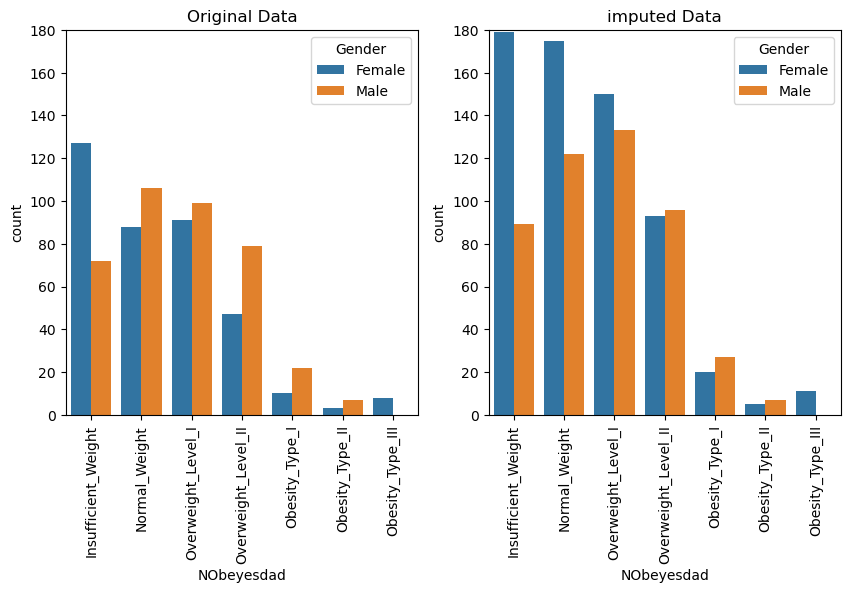

In [124]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x="NObeyesdad", data=train_set_df, hue="Gender", ax=ax1)
ax1.set_title("Original Data")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylim(0,180)
sns.countplot(x="NObeyesdad", data=new_obesity, hue="Gender", ax=ax2)
ax2.set_title("imputed Data")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_ylim(0,180)
plt.show()

Like for "FAVC", the imputer changed the distribution pattern of "Gender" among the classes. Notably, once again the most stricking difference appears in *Normal_Weight* where most of the missing "Gender" were imputed to Female.  
Hence, the imputer must have used one or multiple features to decide for female value. In other words, there is an homogenisation of the values in this/these feature(s) in the female category. 

In [125]:
train_set_df.groupby("Gender", observed=True)["NObeyesdad"].value_counts(dropna=False)

Gender  NObeyesdad         
Female  Insufficient_Weight    127
        Overweight_Level_I      91
        Normal_Weight           88
        Overweight_Level_II     47
        Obesity_Type_I          10
        Obesity_Type_III         8
        Obesity_Type_II          3
Male    Normal_Weight          106
        Overweight_Level_I      99
        Overweight_Level_II     79
        Insufficient_Weight     72
        Obesity_Type_I          22
        Obesity_Type_II          7
        Obesity_Type_III         0
Name: count, dtype: int64

In [126]:
new_obesity.groupby("Gender")["NObeyesdad"].value_counts(dropna=False)

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\1265887194.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_obesity.groupby("Gender")["NObeyesdad"].value_counts(dropna=False)


Gender  NObeyesdad         
Female  Insufficient_Weight    179
        Normal_Weight          175
        Overweight_Level_I     150
        Overweight_Level_II     93
        Obesity_Type_I          20
        Obesity_Type_III        11
        Obesity_Type_II          5
Male    Overweight_Level_I     133
        Normal_Weight          122
        Overweight_Level_II     96
        Insufficient_Weight     89
        Obesity_Type_I          27
        Obesity_Type_II          7
        Obesity_Type_III         0
Name: count, dtype: int64

### **Logistic regression to determine the gender**  
One way to determine whether there is/are feature(s) helpful to determine the gender is to use again a logistic regression. 

In [127]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1107 non-null   int32  
 1   Age                             1107 non-null   float64
 2   Height                          1107 non-null   float64
 3   Weight                          1107 non-null   float64
 4   family_history_with_overweight  1107 non-null   int32  
 5   FAVC                            1107 non-null   int32  
 6   FCVC                            1107 non-null   float64
 7   NCP                             1107 non-null   float64
 8   SMOKE                           1107 non-null   int32  
 9   CH2O                            1107 non-null   float64
 10  SCC                             1107 non-null   int32  
 11  FAF                             1107 non-null   float64
 12  TUE                             11

In [128]:
X_FM = X.drop(["Gender","BMI","NObeyesdad_num"], axis=1)
y_FM = X["Gender"].values

In [129]:
features_X_FM = X_FM.columns

In [130]:
X_FM_scale = stScale.fit_transform(X_FM)

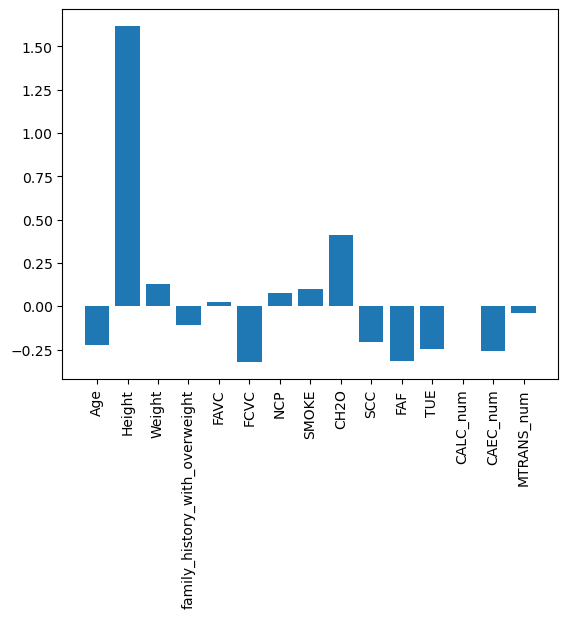

In [131]:
gender_logReg = LogisticRegression()
gender_logReg.fit(X_FM_scale,y_FM)
coefs_gender = gender_logReg.coef_


plt.bar(x=features_X_FM, height=coefs_gender[0])
plt.xticks(rotation=90)
plt.show()

It's not surprising to see "Height" as the most "heavy" feature for gender discrimination. Women are on average smaller than men. Note that "Weight" is actually not that heavy in the gender discrimination, suggesting that "Gender" is not that heavy in the weight class discrimination in this dataset.  
Interestingly the amount of water consumed (CH2O) is second (although far behind "Height").  

Taken together with the drastic change of distribution of "Gender" in *Normal_Weight* class, we can suppose that in this class the missing gender were on average shorter.

### **Logistic regression in female and in males**

To test if among the 2 genders there are different features that will strike more to discriminate a class, I am dividing the dataset into 2 sub-datasets: males and females and run again a logistic regression.  

In [132]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1107 non-null   int32  
 1   Age                             1107 non-null   float64
 2   Height                          1107 non-null   float64
 3   Weight                          1107 non-null   float64
 4   family_history_with_overweight  1107 non-null   int32  
 5   FAVC                            1107 non-null   int32  
 6   FCVC                            1107 non-null   float64
 7   NCP                             1107 non-null   float64
 8   SMOKE                           1107 non-null   int32  
 9   CH2O                            1107 non-null   float64
 10  SCC                             1107 non-null   int32  
 11  FAF                             1107 non-null   float64
 12  TUE                             11

In [133]:
X["NObeyesdad"] = Encod_y.reverse_transform(X,"NObeyesdad_num")
X.drop("NObeyesdad_num", axis=1, inplace=True)


In [134]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1107 non-null   int32  
 1   Age                             1107 non-null   float64
 2   Height                          1107 non-null   float64
 3   Weight                          1107 non-null   float64
 4   family_history_with_overweight  1107 non-null   int32  
 5   FAVC                            1107 non-null   int32  
 6   FCVC                            1107 non-null   float64
 7   NCP                             1107 non-null   float64
 8   SMOKE                           1107 non-null   int32  
 9   CH2O                            1107 non-null   float64
 10  SCC                             1107 non-null   int32  
 11  FAF                             1107 non-null   float64
 12  TUE                             11

In [135]:
X["NObeyesdad"] = X["NObeyesdad"].astype("category")
X["NObeyesdad"] = X["NObeyesdad"].cat.reorder_categories(classes)

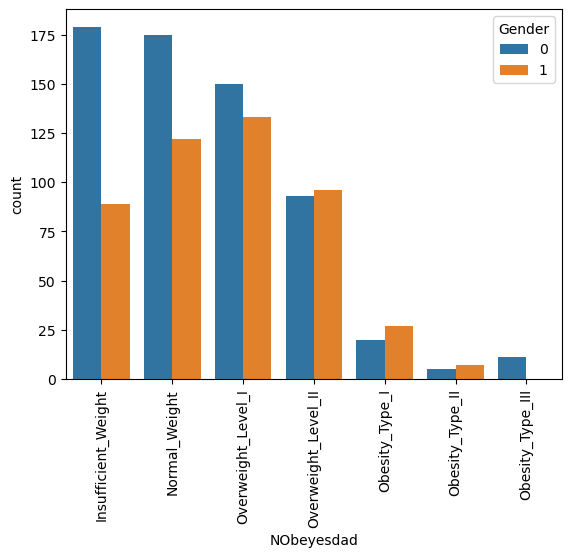

In [136]:
sns.countplot(x="NObeyesdad", data=X, hue="Gender")
plt.xticks(rotation=90)
plt.show()

In [137]:
list_binom_bool_dict[0]

{'Female': 0, 'Male': 1}

In [138]:
X_fem = X[X["Gender"] == 0].copy()
X_mal = X[X["Gender"] == 1].copy()
y_fem = X_fem["NObeyesdad"]
y_mal = X_mal["NObeyesdad"]
X_fem.drop(["NObeyesdad","Weight","Gender","BMI"], axis=1, inplace=True)
X_mal.drop(["NObeyesdad","Weight","Gender","BMI"], axis=1, inplace=True)


In [139]:
y_mal.value_counts()

NObeyesdad
Overweight_Level_I     133
Normal_Weight          122
Overweight_Level_II     96
Insufficient_Weight     89
Obesity_Type_I          27
Obesity_Type_II          7
Obesity_Type_III         0
Name: count, dtype: int64

In [140]:
y_mal = y_mal.cat.remove_categories(["Obesity_Type_III"])

order_mal_classes = ["Insufficient_Weight","Normal_Weight","Overweight_Level_I","Overweight_Level_II","Obesity_Type_I","Obesity_Type_II"]
y_mal = y_mal.cat.reorder_categories(order_mal_classes, ordered=True)
y_classes = y_mal.cat.categories

In [141]:
y_fem.value_counts()

NObeyesdad
Insufficient_Weight    179
Normal_Weight          175
Overweight_Level_I     150
Overweight_Level_II     93
Obesity_Type_I          20
Obesity_Type_III        11
Obesity_Type_II          5
Name: count, dtype: int64

In [142]:
dict_y

{'Insufficient_Weight': 0,
 'Normal_Weight': 1,
 'Overweight_Level_I': 2,
 'Overweight_Level_II': 3,
 'Obesity_Type_I': 4,
 'Obesity_Type_II': 5,
 'Obesity_Type_III': 6}

In [143]:
female_logReg = LogisticRegression(max_iter=1000)
male_logReg = LogisticRegression(max_iter=1000)

X_fem_scale = stScale.fit_transform(X_fem)
X_mal_scale = stScale.fit_transform(X_mal)

female_logReg.fit(X_fem_scale, y_fem)
male_logReg.fit(X_mal_scale, y_mal)

fem_coefs = female_logReg.coef_
mal_coefs = male_logReg.coef_

In [144]:
df_fem_coefs = pd.DataFrame(fem_coefs, columns=X_fem.columns, index=classes)
df_mal_coefs = pd.DataFrame(mal_coefs, columns=X_mal.columns, index=y_classes)

### **Females**

In [145]:
@widgets.interact
def most_important_negFeature(weight_class = classes):
    print(most_import_negFeature(df_fem_coefs, weight_class))

interactive(children=(Dropdown(description='weight_class', options=('Insufficient_Weight', 'Normal_Weight', 'O…

In [146]:
@widgets.interact
def most_important_posFeature(weight_class = classes):
    print(most_import_posFeature(df_fem_coefs, weight_class))

interactive(children=(Dropdown(description='weight_class', options=('Insufficient_Weight', 'Normal_Weight', 'O…

In [147]:
fem_high_coef = highest_coef_class(df_fem_coefs,classes)
fem_high_coef

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\3471518129.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dici[sorted_feature[i]] = sorted_coef[i]


{'Insufficient_Weight': {'family_history_with_overweight': 1.2617325718039756,
  'Age': 1.1332468813330654,
  'CAEC_num': 0.996241848476176},
 'Normal_Weight': {'CAEC_num': 0.584943391838701,
  'family_history_with_overweight': 0.5581365243448082,
  'FAF': 0.5043282144824979},
 'Overweight_Level_I': {'FCVC': 0.7954692657367396,
  'family_history_with_overweight': 0.6124807247482512,
  'NCP': 0.5332651921185819},
 'Overweight_Level_II': {'Age': 0.971544931679851,
  'MTRANS_num': 0.526997843474062,
  'CALC_num': 0.5189353721460725},
 'Obesity_Type_I': {'FCVC': 1.8692477726263101,
  'CAEC_num': 1.1582836783917092,
  'family_history_with_overweight': 0.9292390162949468},
 'Obesity_Type_II': {'SCC': 0.742919330628022,
  'FAVC': 0.654183689765482,
  'MTRANS_num': 0.638065851721054},
 'Obesity_Type_III': {'SCC': 0.48462266714626806,
  'FAVC': 0.4253442044913666,
  'family_history_with_overweight': 0.31091316604752217}}

### **Males**

In [148]:
@widgets.interact
def most_important_negFeature(weight_class = y_classes):
    print(most_import_negFeature(df_mal_coefs, weight_class))

interactive(children=(Dropdown(description='weight_class', options=('Insufficient_Weight', 'Normal_Weight', 'O…

In [149]:
@widgets.interact
def most_important_posFeature(weight_class = y_classes):
    print(most_import_posFeature(df_mal_coefs, weight_class))

interactive(children=(Dropdown(description='weight_class', options=('Insufficient_Weight', 'Normal_Weight', 'O…

In [150]:
male_high_coef = highest_coef_class(df_mal_coefs,y_classes)
male_high_coef

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\3471518129.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dici[sorted_feature[i]] = sorted_coef[i]


{'Insufficient_Weight': {'Age': 3.332502583568588,
  'FAVC': 0.9763185416405904,
  'TUE': 0.8238280817498622},
 'Normal_Weight': {'CAEC_num': 1.0033382988984902,
  'family_history_with_overweight': 0.6062815252576844,
  'FAVC': 0.5467635737801066},
 'Overweight_Level_I': {'Age': 1.0159590996083214,
  'CAEC_num': 0.7748505253781763,
  'FAVC': 0.4271668390624365},
 'Overweight_Level_II': {'CAEC_num': 1.9396760823665908,
  'Age': 1.1580701391692545,
  'MTRANS_num': 0.9302325327340438},
 'Obesity_Type_I': {'TUE': 0.3773827236000434,
  'CAEC_num': 0.3609198611520373,
  'Age': 0.29796815514771213},
 'Obesity_Type_II': {'Age': 1.346475429024171,
  'NCP': 0.5804100493225178,
  'family_history_with_overweight': 0.5119242625676309}}

### **Females vs Males**

In [151]:
def dict_3_high_coefs(df, classes):
    df_abs = df.abs()
    dict_coefs = {}
    for cla in classes:
        dict_coefs[cla] = list(df_abs.loc[cla].sort_values(ascending=False).index[:3])
    return dict_coefs

dict_fem_coefs = dict_3_high_coefs(df_fem_coefs, classes)
dict_mal_coefs = dict_3_high_coefs(df_mal_coefs, y_classes)

In [152]:
@widgets.interact
def best_coef_gender(fem_class = classes, mal_class = y_classes):
    print(f"In females: {dict_fem_coefs[fem_class]};\nIn males: {dict_mal_coefs[mal_class]}")

interactive(children=(Dropdown(description='fem_class', options=('Insufficient_Weight', 'Normal_Weight', 'Over…

While "Age" was the most powerful feature for *Insufficient_Weight* discrimination

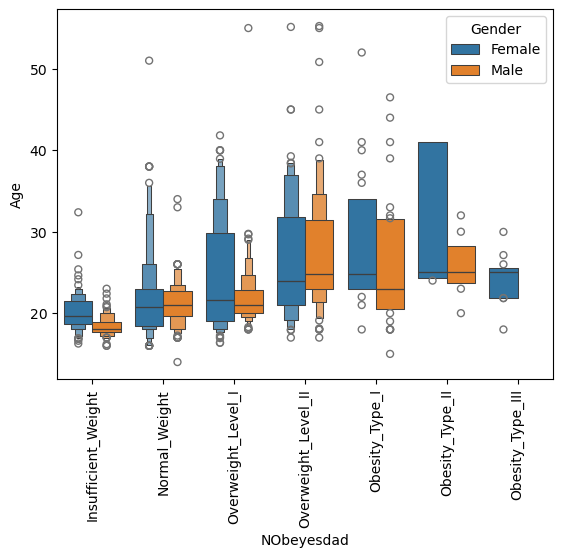

In [153]:
sns.boxenplot(x="NObeyesdad", y="Age", data=new_obesity, hue="Gender")
plt.xticks(rotation=90)
plt.show()

We can indeed observe here that the median of Age and its distribution are much reduced in males in the *Insufficient_Weight* class. This allows it to stay significantly younger than the other other classes (even with *Obesity_Type_II* which only has 7 individuals).  
As a consequence, "Age" in the female *Insuficient_Weight* becomes older and although its distribution remains narrow compared to the other classes (still informative for the class determination), it losts significance with other classes, like for example *Normal_Weight*.

In [154]:
print(y_fem.value_counts(sort=False))
print(y_mal.value_counts(sort=False))

NObeyesdad
Insufficient_Weight    179
Normal_Weight          175
Overweight_Level_I     150
Overweight_Level_II     93
Obesity_Type_I          20
Obesity_Type_II          5
Obesity_Type_III        11
Name: count, dtype: int64
NObeyesdad
Insufficient_Weight     89
Normal_Weight          122
Overweight_Level_I     133
Overweight_Level_II     96
Obesity_Type_I          27
Obesity_Type_II          7
Name: count, dtype: int64


In [155]:
males = new_obesity[new_obesity["Gender"] == "Male"].copy()
females = new_obesity[new_obesity["Gender"] == "Female"].copy()
males["NObeyesdad"] = males["NObeyesdad"].cat.remove_categories(["Obesity_Type_III"])

In [156]:
multiple_MannWitU(males,col_name="Age",target_col="NObeyesdad")

{('Insufficient_Weight', 'Normal_Weight'): 5.62337846660059e-16,
 ('Insufficient_Weight', 'Overweight_Level_I'): 1.2129413001136216e-25,
 ('Insufficient_Weight', 'Overweight_Level_II'): 5.871737226621045e-26,
 ('Insufficient_Weight', 'Obesity_Type_I'): 9.669096683729573e-08,
 ('Insufficient_Weight', 'Obesity_Type_II'): 0.000309159154834897,
 ('Normal_Weight', 'Overweight_Level_I'): 0.7218932390886191,
 ('Normal_Weight', 'Overweight_Level_II'): 4.018538159900101e-16,
 ('Normal_Weight', 'Obesity_Type_I'): 0.020208786141431172,
 ('Normal_Weight', 'Obesity_Type_II'): 0.03389477940801882,
 ('Overweight_Level_I', 'Overweight_Level_II'): 4.763348536078617e-14,
 ('Overweight_Level_I', 'Obesity_Type_I'): 0.13711482328778266,
 ('Overweight_Level_I', 'Obesity_Type_II'): 0.09039213858937557,
 ('Overweight_Level_II', 'Obesity_Type_I'): 4.58840864425821,
 ('Overweight_Level_II', 'Obesity_Type_II'): 12.893380342713755,
 ('Obesity_Type_I', 'Obesity_Type_II'): 10.989819434277575}

In [157]:
multiple_MannWitU(females,col_name="Age",target_col="NObeyesdad")

{('Insufficient_Weight', 'Normal_Weight'): 1.4659666483639913,
 ('Insufficient_Weight', 'Overweight_Level_I'): 3.14010665712434e-06,
 ('Insufficient_Weight', 'Overweight_Level_II'): 4.200051131113751e-15,
 ('Insufficient_Weight', 'Obesity_Type_I'): 4.234679173813924e-08,
 ('Insufficient_Weight', 'Obesity_Type_II'): 0.0044637179745128834,
 ('Insufficient_Weight', 'Obesity_Type_III'): 0.0022878263566488144,
 ('Normal_Weight', 'Overweight_Level_I'): 0.005410037354192359,
 ('Normal_Weight', 'Overweight_Level_II'): 1.8032995495720747e-08,
 ('Normal_Weight', 'Obesity_Type_I'): 9.871137802722897e-05,
 ('Normal_Weight', 'Obesity_Type_II'): 0.06373537566233824,
 ('Normal_Weight', 'Obesity_Type_III'): 0.15545298464113433,
 ('Overweight_Level_I', 'Overweight_Level_II'): 0.09249634829899267,
 ('Overweight_Level_I', 'Obesity_Type_I'): 0.1015673203117946,
 ('Overweight_Level_I', 'Obesity_Type_II'): 0.5947392089176655,
 ('Overweight_Level_I', 'Obesity_Type_III'): 6.213051421916081,
 ('Overweight_Leve

There are more females than males in *Insufficient_Weight*, however the males there are much younger than all the other people (male females in other clasess and also younger than female in this class).  
Females are on average more likely to be shorter than males (not surprising). Since the imputer imputed much more females than males in all classes, we can suppose that the missing "Gender" values were shorter (I include the manual imputed height deduced from the median BMI). 
*Normal_Weight* is the class where the distribution of FAVC and gender changed radically

In [158]:
miss_Height = {}
for clas in classes:
    miss_val = len(train_set_df.loc[(train_set_df["NObeyesdad"] == clas)&\
                                    (train_set_df["Height"].isna())])
    miss_Height[clas] = miss_val
miss_Height

{'Insufficient_Weight': 21,
 'Normal_Weight': 17,
 'Overweight_Level_I': 24,
 'Overweight_Level_II': 11,
 'Obesity_Type_I': 3,
 'Obesity_Type_II': 3,
 'Obesity_Type_III': 0}

### **Height**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


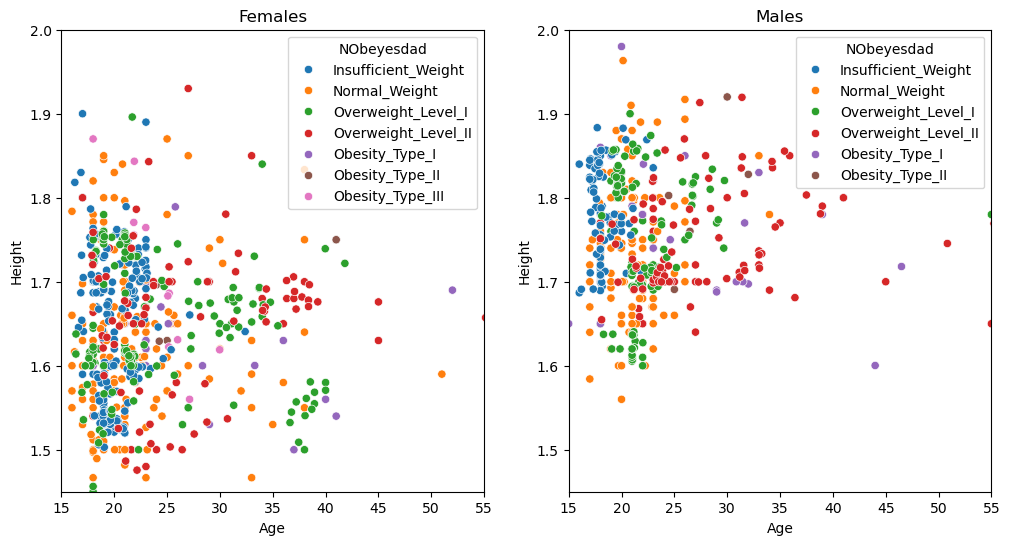

In [159]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(x="Age", y="Height", data=females, hue="NObeyesdad", ax=ax1)
ax1.set_xlim(15,55)
ax1.set_ylim(1.45,2)
ax1.set_title("Females")
plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
sns.scatterplot(x="Age", y="Height", data=males, hue="NObeyesdad", ax=ax2)
ax2.set_ylim(1.45,2)
ax2.set_xlim(15,55)
ax2.set_title("Males")
plt.show()

The scatter plot nicely emphasize the height difference in all classes between male and female.  
Furthermore the *Insufficient_Weight* class also nicely outstands from the other classes in the male dataset. 

## **3) Snacking and obesity**  

CAEC: Consumption of food between meals  
NCP: Number of daily meals

In [160]:
new_obesity["CAEC"].value_counts()

CAEC
Sometimes     828
Frequently    186
no             57
Always         36
Name: count, dtype: int64

In [161]:
train_set_df["CAEC"].value_counts(dropna=False)

CAEC
Sometimes     550
NaN           320
Frequently    166
Always         36
no             35
Name: count, dtype: int64

In [162]:
train_set_df["NObeyesdad"].value_counts()

NObeyesdad
Normal_Weight          297
Overweight_Level_I     283
Insufficient_Weight    268
Overweight_Level_II    189
Obesity_Type_I          47
Obesity_Type_II         12
Obesity_Type_III        11
Name: count, dtype: int64

C:\Users\Angelique\AppData\Local\Temp\ipykernel_21428\4230352729.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(classes,rotation=90)


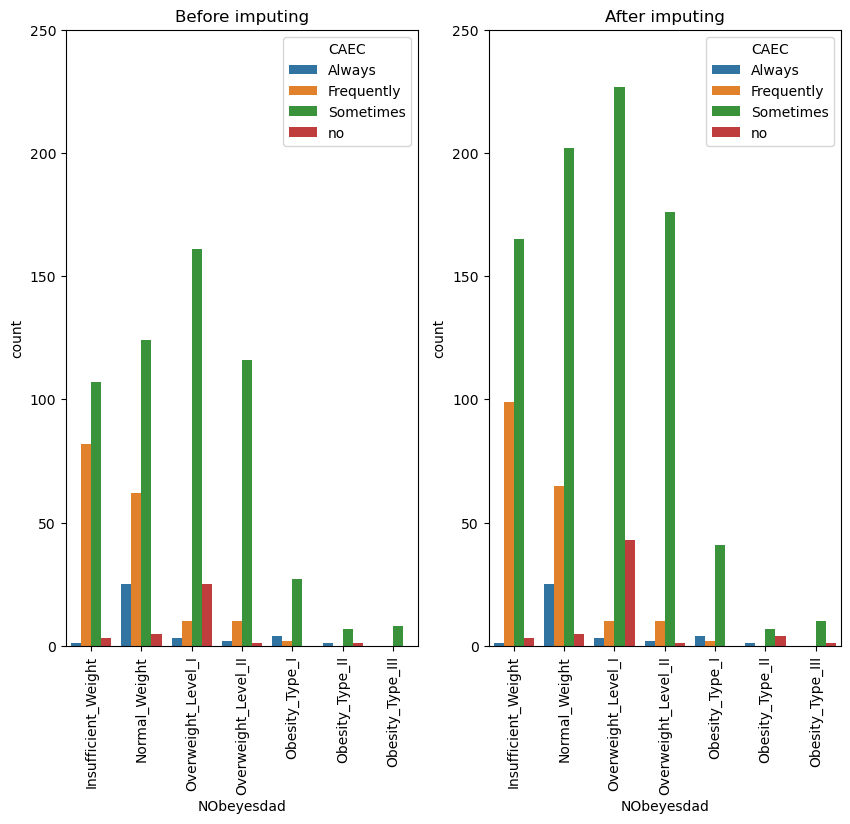

In [163]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
sns.countplot(x="NObeyesdad", data=train_set_df, hue="CAEC", ax=ax1)
ax1.set_xticklabels(classes,rotation=90)
ax1.set_title("Before imputing")
ax1.set_ylim(0,250)
sns.countplot(x="NObeyesdad", data=new_obesity, hue="CAEC", ax=ax2)
ax2.set_title("After imputing")
ax2.set_ylim(0,250)
plt.xticks(rotation=90)
plt.show()

In [164]:
train_set_df["CAEC"].value_counts(dropna=False)

CAEC
Sometimes     550
NaN           320
Frequently    166
Always         36
no             35
Name: count, dtype: int64

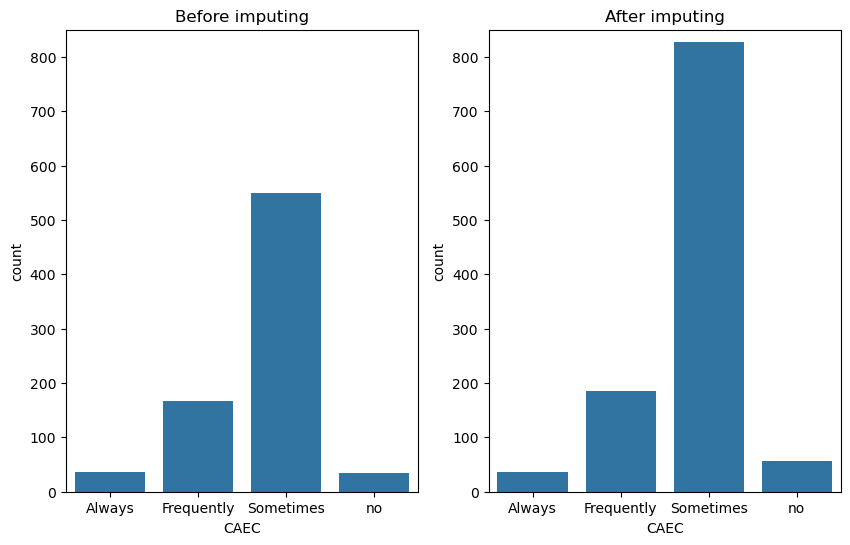

In [165]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
sns.countplot(x=train_set_df["CAEC"], ax=ax1)
ax1.set_title("Before imputing")
ax1.set_ylim(0,850)
sns.countplot(x=new_obesity["CAEC"], ax=ax2)
ax2.set_title("After imputing")
ax2.set_ylim(0,850)
plt.show()

Apart from *Insufficient_Weight* where a few missing "CAEC" were imputed to **Frequently** and some in *Overweight_Level_I* to **no**, all the other missing "CAEC" were imputed to **Sometimes**.
Why most of the imputed **no** are in the *Overweight_Level_I* class is the question we should ask ourselves. 

In [166]:
orig_no_OverI = train_set_df[(train_set_df["NObeyesdad"] == "Overweight_Level_I")&\
                                 (train_set_df["CAEC"] == "no")].copy()

new_no_OverI = new_obesity[(new_obesity["NObeyesdad"] == "Overweight_Level_I")&(new_obesity["CAEC"] == "no")].copy()

In [167]:
new_no_OverI = new_no_OverI.loc[~(new_no_OverI["ID"].isin(orig_no_OverI["ID"]))]

In [168]:
print(orig_no_OverI)

      ID  Gender        Age    Height     Weight  \
747  750    Male  21.000000  1.617469  68.869791   
760  763    Male        NaN  1.629194  70.000000   
761  764     NaN  21.000000  1.620000  70.000000   
762  765    Male  21.000000  1.620000  70.000000   
768  771    Male  21.029633  1.607082  67.722222   
803  806    Male        NaN  1.636974  70.000000   
804  807    Male        NaN  1.640370  70.000000   
807  810     NaN  21.012542  1.615145  68.653347   
808  811     NaN  21.071195  1.616467  68.771850   
822  825     NaN  21.000000  1.620000  70.000000   
831  834    Male        NaN  1.636974  70.000000   
832  835    Male  21.000000  1.620000  70.000000   
842  845     NaN        NaN  1.604697  68.016472   
843  846  Female  21.455463  1.611000  68.107866   
893  896     NaN  21.037514  1.636592  69.967348   
894  897     NaN        NaN  1.621412  70.000000   
898  901  Female  21.000000  1.618148  68.981403   
911  914    Male  21.000000  1.610209  68.865008   
912  915    

In [169]:
orig_no_OverI["Height"].describe()

count    25.000000
mean      1.619953
std       0.009905
min       1.604697
25%       1.612556
50%       1.620000
75%       1.621412
max       1.640370
Name: Height, dtype: float64

In [170]:
new_no_OverI["Height"].describe()

count    18.000000
mean      1.622111
std       0.026239
min       1.600000
25%       1.611268
50%       1.620000
75%       1.620000
max       1.718884
Name: Height, dtype: float64

In [171]:
orig_no_OverI["Gender"].value_counts(normalize=True, dropna=False)

Gender
Male      0.52
NaN       0.36
Female    0.12
Name: proportion, dtype: float64

In [172]:
new_no_OverI["Gender"].value_counts(normalize=True)

Gender
Male      0.666667
Female    0.333333
Name: proportion, dtype: float64

It seems that the "no" snackers in the *Overweight_Level_I* are more likely to be small men.

In [173]:
miss_Gend_no = orig_no_OverI.loc[orig_no_OverI["Gender"].isna()]
gend_no_OverI = new_obesity.loc[new_obesity["ID"].isin(miss_Gend_no["ID"])]

In [174]:
gend_no_OverI["Gender"].value_counts(dropna=False, normalize=True)

Gender
Male      0.555556
Female    0.444444
Name: proportion, dtype: float64

Because the "no" snackers in this class are more likely to be 1.6m tall, the imputer imputed the missing "Gender" values only slightly more towards male.

In [175]:
orig_no_OverI["Age"].describe()

count    17.000000
mean     21.060104
std       0.416980
min      19.858973
25%      21.000000
50%      21.000000
75%      21.037514
max      22.018228
Name: Age, dtype: float64

In [176]:
new_no_OverI["Age"].describe()

count    18.000000
mean     20.983095
std       1.013403
min      17.781183
25%      21.000000
50%      21.000000
75%      21.553523
max      22.000000
Name: Age, dtype: float64

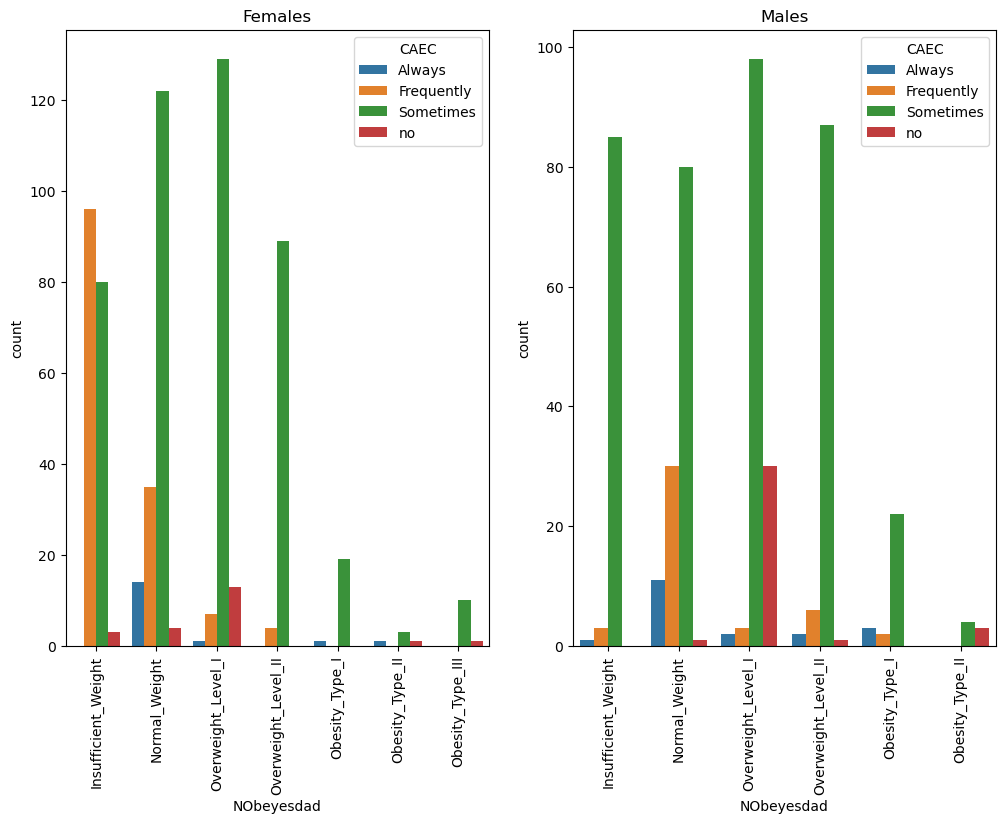

In [177]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (12,8))
sns.countplot(x="NObeyesdad", data=females, hue="CAEC", ax=ax1)
ax1.set_title("Females")
ax1.tick_params("x", rotation=90)
sns.countplot(x="NObeyesdad", data=males, hue="CAEC", ax=ax2)
ax2.tick_params("x", rotation=90)
ax2.set_title("Males")
plt.show()

In [179]:
len(new_obesity.loc[(new_obesity["NObeyesdad"] == "Overweight_Level_I")&(new_obesity["CAEC"] == "no")])

43

### **Conclusion for snacking**  
In this dataset snacking is not a factor for overweight and obesity. Indeed, *Normal_Weight* is the class that has the highest amount of **Always** snackers and together with *Insufficient_Weight* class they have the most number of **Frequently** snackers.  
Interestingly, most of the **no** snackers are *Overweight_Level_I* small men. The imputer used the class information and the height to decide on the **no**.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


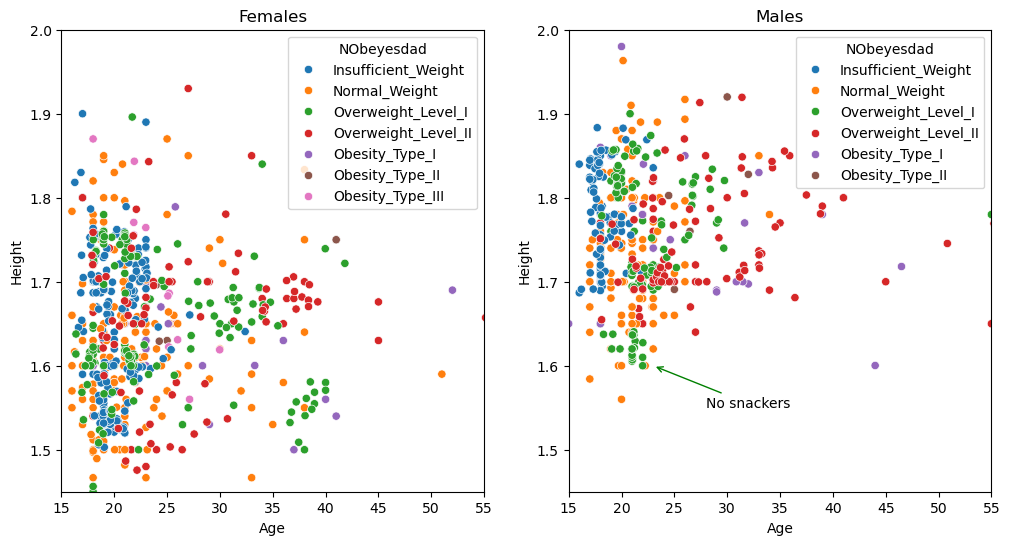

In [178]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(x="Age", y="Height", data=females, hue="NObeyesdad", ax=ax1)
ax1.set_xlim(15,55)
ax1.set_ylim(1.45,2)
ax1.set_title("Females")
plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
sns.scatterplot(x="Age", y="Height", data=males, hue="NObeyesdad", ax=ax2)
ax2.set_ylim(1.45,2)
ax2.set_xlim(15,55)
ax2.annotate("No snackers", xy=(23,1.6), xytext=(28,1.55), arrowprops={"arrowstyle":"->", "color":"green"})
ax2.set_title("Males")
plt.show()

We have here 5 dimensions (or features) that define the small group (43) indicated by the green arrow:
- NObeyesdad: *Overweight_Level_I*;  
- Gender: Male;  
- Age: average 21 years old;
- Height: average 1.62m
- CAEC (snacking): No 

## **conclusion**  

The challenge of this dataset was the wide presence of missing values.  
Sadly, although the dataset is called obesity, because of the small sizes of the *Obesity* classes, it was impossible to draw any clear conclusions for these particular classes. More data is needed.   

However, I took advantage of the output of my KNNImputer to get insights.  
Indeed, what the logistic regression suggested is that there no specific features (apart from "Age") which is more helpful than others to discriminate a class. Basically, it's the specific combination of features that will determine the class.
Nonetheless, the KNNImputer could help me find the features that helped it impute missing values.  
For example, to discriminate the missing gender, "height" was playing a very important role (which is logic). More interestingly, using the output of my imputer, I could define a group of young, small slightly overweight (overweight level I) men who do not snack at all.  

Since I do not know from which research project this dataset is coming from, I cannot generalise the insights I am seeing here. Notably, the fact that the overweight and obese classes eat frequently vegetables but do not snack much was very surprising. Perhaps those persons already started a program to loose weight and answered a questionnaire to the present time (hence while they were in the program, so no snacking and more vegetables eating). In addition, the dataset is quite young (early 20's), which another argument to think that the overweight and obese persons are already trying to loose weight through a specific program. 